# JETSCAPE VAH: Emulator building and checks

### Import all the necessary libraries that we mention above

In [1]:
import sys
import os
import pickle
import numpy as np
import seaborn as sns
import pandas as pd
import math
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from numpy.linalg import inv
import sklearn, matplotlib
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process import kernels as krnl
import scipy.stats as st
from scipy import optimize

import uncertainty_toolbox as uct

import ptemcee
import h5py
from scipy.linalg import lapack
from multiprocessing import Pool
from multiprocessing import cpu_count
import time
sns.set("notebook")

### Define some name variables

In [2]:
name="JETSCAPEVAHEmulation"
#Saved emulator name
EMU='PbPb2760_vah_emulators.dat'
# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "Data/"

In [3]:
if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

### Step 1: Physics model.

#### 1. 1: Simulation data. (Pb Pb collisions at 2.76 TeV)

Bayesian inference require millions of simulations. Simulation is computationally expensive! We need to build emulators to replace computationally expensive simulation.

To build emulators we need training data from the simulation. To get training data we simulate Pb Pb collisions at 2.76 TeV for a Latin Hyper Cube design.

In [4]:
# Design points
design = pd.read_csv('sliced_VAH_090321.txt', delimiter = ' ')
design_validation = pd.read_csv('sliced_VAH_090321_test.txt', delimiter = ' ')

In [5]:
design.shape

(500, 16)

In [6]:
#drop tau_initial parameter for now because we keep it fixed
design = design.drop(labels='tau_initial', axis=1)
design_validation = design_validation.drop(labels='tau_initial', axis=1)

In [7]:
# We have only simulated first 150 design points for now
design = design.iloc[0:300]
design_validation = design_validation.iloc[0:50]



In [8]:
design.shape

(300, 15)

In [9]:
design_validation.shape

(50, 15)

Run the simulation for these design points and calculate the observables!

In [10]:
#### Block 5 #### Please refer to this number in your questions

#Simulation outputs at the design points
simulation = pd.read_csv(filepath_or_buffer="mean_for_300_sliced_200_events_design", index_col=0)
simulation_sd = pd.read_csv(filepath_or_buffer="sd_for_300_sliced_200_events_design", index_col=0)

#Simulation outputs at the design points
simulation_50 = pd.read_csv(filepath_or_buffer="mean_for_50_sliced_200_events_design", index_col=0)
simulation_sd_50 = pd.read_csv(filepath_or_buffer="sd_for_50_sliced_200_events_design", index_col=0)
design_50 = design.iloc[0:50]

In [11]:
np.all(np.isclose(simulation_50.values,simulation.values[0:50,:], equal_nan =True))

True

In [12]:
np.all(np.isclose(simulation_sd_50.values,simulation_sd.values[0:50,:], equal_nan =True))

True

In [13]:
# Load testing data

validation = pd.read_csv(filepath_or_buffer="mean_for_50_sliced_200_events_test_design", index_col=0)
validation_sd = pd.read_csv(filepath_or_buffer="sd_for_50_sliced_200_events_test_design", index_col=0)

In [14]:
# Load experimental data
experiment=pd.read_csv(filepath_or_buffer="PbPb2760_experiment",index_col=0)



In [15]:
# Gather what type of experimental data do we have. 
exp_label=[]
for i in experiment.columns:
    words=i.split('[')
    exp_label.append(words[0]+'_['+words[1])

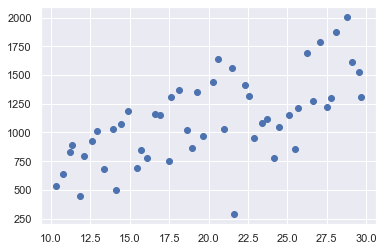

In [16]:
plt.scatter(design_validation.values[0:50,0],validation.values[:,0])

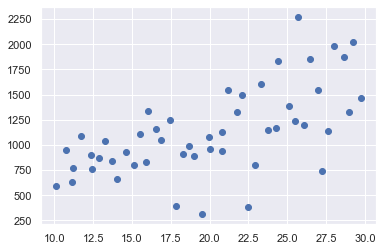

In [17]:
plt.scatter(design.values[0:50,0],simulation_50.values[:,0])

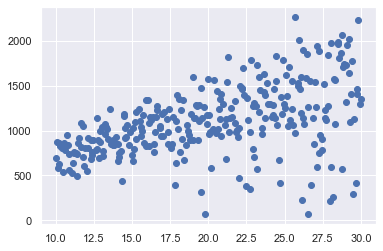

In [18]:
#simple test to see how particle yields change with the Normalization
plt.scatter(design.values[:,0],simulation.values[:,0])

In [19]:
# Only keep simulation data that we have corresponding experimental data
simulation=simulation[exp_label]
simulation_sd=simulation_sd[exp_label]

validation = validation[exp_label]
validation_sd = validation_sd[exp_label]

simulation_50 = simulation_50[exp_label]
simulation_sd_50 = simulation_sd_50[exp_label]

### After talking with Matt we decided to get rid of observables that are too difficult to calculate for now and do dimensional reduction, emulator building and calibration with observables that have smaller statistical variance.


#### We will not consider PT fluctuations and flow coefficients for now, and proceed with other observables.

In [20]:
exp_label[-32]

'pT_fluct_[0 5]'

In [21]:
selected_observables = exp_label[0:-32]
print(f'Last item on the selected observable is {selected_observables[-1]}')

Last item on the selected observable is mean_pT_proton_[60 70]


In [22]:
simulation=simulation[selected_observables]
simulation_sd=simulation_sd[selected_observables]
print(f'Shape of the constrained simulation output {simulation.shape}')

Shape of the constrained simulation output (300, 78)


In [23]:
validation=validation[selected_observables]
validation_sd=validation_sd[selected_observables]
print(f'Shape of the constrained simulation output {validation.shape}')

Shape of the constrained simulation output (50, 78)


In [24]:
simulation_50=simulation_50[selected_observables]
simulation_50_sd=simulation_sd_50[selected_observables]
print(f'Shape of the constrained simulation output {simulation_50.shape}')

Shape of the constrained simulation output (50, 78)


In [25]:
np.argwhere(simulation_sd_50.values<0)[:,0]

array([ 0,  0,  0,  6,  6,  7, 24, 24, 24, 30, 30, 34])

In [26]:
np.argwhere(simulation_sd.values<0)[:,0]

array([], dtype=int64)

Important to note if there are negative sd that is because of the way we calculate the vn error. It gets divided by vn for some reason and when vn is negative sd becomes negative. This specially tend to happen when we have too small of a event set per design point. 


Why do we have these zero standard errors for some observables?

In [27]:
def find_bad_designs(design , simulation_df, simulation_sd_df):
    zero_sd_index=np.unique(np.argwhere(np.isclose(simulation_sd_df,0))[:,0])    
    negative_sd_index=np.unique(np.argwhere(simulation_sd_df.values<0)[:,0])
    nan_index=np.unique(np.argwhere(np.isnan(simulation_df).values)[:,0])
    drop_index= np.unique(np.concatenate((nan_index.flatten(),zero_sd_index.flatten(),negative_sd_index.flatten())))
    print('###################')
    print('Nan values are in:')
    print(nan_index)
    print('###################')
    print('Negative variance in:')
    print(negative_sd_index)
    print('###################')
    print('Zero variance in:')
    print(zero_sd_index)
    print('###################')
    print('Drop these design points:')
    print(drop_index)
    clean_simulation = simulation_df.drop(drop_index)
    clean_sim_sd = simulation_sd_df.drop(drop_index)
    clearn_design = design.drop(drop_index)
    return nan_index, negative_sd_index, zero_sd_index, drop_index, clean_simulation, clean_sim_sd, clearn_design

In [28]:
drop_index= np.array([19, 23, 31, 32, 71, 91, 92, 98, 129, 131, 146, 162, 171, 174, 184, 190, 194, 195, 198,
                     245, 248, 266, 283, 286, 291, 299, ])
drop_index_vl= np.array([29, 35, ])

In [29]:
simulation = simulation.drop(drop_index)
simulation_sd = simulation_sd.drop(drop_index)
design = design.drop(drop_index)
#_,_,_,_, simulation, simulation_sd, design = find_bad_designs(design, simulation,simulation_sd)

In [30]:
_,_,_,_, simulation_50, simulation_sd_50, design_50 = find_bad_designs(design_50, simulation_50,simulation_sd_50)

###################
Nan values are in:
[]
###################
Negative variance in:
[ 0  6  7 24 30 34]
###################
Zero variance in:
[]
###################
Drop these design points:
[ 0  6  7 24 30 34]


In [31]:
_, _, _, _, validation, validation_sd, design_validation = find_bad_designs(design_validation, validation,validation_sd)

###################
Nan values are in:
[]
###################
Negative variance in:
[]
###################
Zero variance in:
[35]
###################
Drop these design points:
[35]


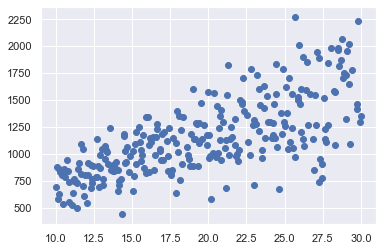

In [32]:
#simple test to see how particle yields change with the Normalization
plt.scatter(design.values[:,0],simulation.values[:,0])

In [33]:
X = design.values
Y = simulation.values

Xv = design_validation.values
Yv = validation.values

print( "X.shape : "+ str(X.shape) )
print( "Y.shape : "+ str(Y.shape) )

print( "Validation X.shape : "+ str(Xv.shape) )
print( "Validation Y.shape : "+ str(Yv.shape) )

X.shape : (274, 15)
Y.shape : (274, 78)
Validation X.shape : (49, 15)
Validation Y.shape : (49, 78)


In [34]:
model_param_dsgn = ['$N$[$2.76$TeV]',
 '$p$',
 '$w$ [fm]',
 '$d_{\\mathrm{min}}$ [fm]',
 '$\\sigma_k$',
 '$T_{\\mathrm{sw}}$ [GeV]',
 '$T_{\\eta,\\mathrm{kink}}$ [GeV]',
 '$(\\eta/s)_{\\mathrm{kink}}$',
 '$a_{\\eta,\\mathrm{low}}$ [GeV${}^{-1}$]',
 '$a_{\\eta,\\mathrm{high}}$ [GeV${}^{-1}$]',
 '$(\\zeta/s)_{\\max}$',
 '$T_{\\zeta,c}$ [GeV]',
 '$w_{\\zeta}$ [GeV]',
 '$\\lambda_{\\zeta}$',
 '$R$']

#### <center> We have load the simulation data from our LHS design!

#### 1.3: Preprocessing and dimensional reduction of the simulation data.

###### Our emulators can train only one observable at a time. Training  emulators for each observable is difficult! We use PCA to reduce dimensionality of our data.

 More details about Singular Value Decomposition (SVD) and Principal Component Analysis (PCA)can be found here.
[Web article](https://intoli.com/blog/pca-and-svd/)

In [35]:
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log1p)
Y_tf = transformer.transform(Y)
Yv_tf = transformer.transform(Yv)

In [36]:
Y_tf

array([[6.37794781, 6.19311563, 6.01841393, ..., 0.63455021, 0.61585161,
        0.60582941],
       [6.85466341, 6.66429959, 6.34525854, ..., 0.71881082, 0.67348936,
        0.62668251],
       [6.4566674 , 6.16999318, 5.97140854, ..., 0.61603152, 0.59463788,
        0.57041374],
       ...,
       [7.63484184, 7.46796058, 7.09307845, ..., 0.83251735, 0.77862997,
        0.71096064],
       [7.406102  , 7.30062751, 7.12049376, ..., 0.85829638, 0.76121841,
        0.686878  ],
       [7.48296749, 7.3450995 , 7.15004862, ..., 0.78171253, 0.76092368,
        0.70570065]])

In [37]:
validation = pd.DataFrame(Yv_tf, columns=validation.keys())

In [38]:
#Scaling the data to be zero mean and unit variance for each observables
SS  =  StandardScaler(copy=True)
#Singular Value Decomposition
u, s, vh = np.linalg.svd(SS.fit_transform(Y_tf), full_matrices=True)
print(f'shape of u {u.shape} shape of s {s.shape} shape of vh {vh.shape}')

shape of u (274, 274) shape of s (78,) shape of vh (78, 78)


##### How many PCs to keep?

/Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  app.launch_new_instance()


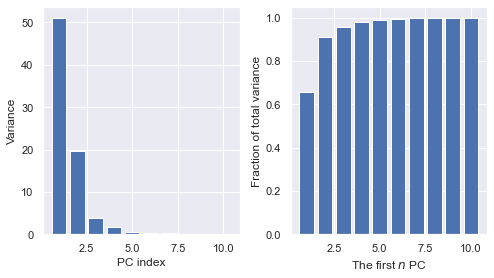

In [39]:
#### Block 8 #### Please refer to this number in your questions
npc = 10 # number of PCs
# print the explained raito of variance
# https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,4))
#importance = pca_analysis.explained_variance_
importance = np.square(s[:npc]/math.sqrt(u.shape[0]-1))
cumulateive_importance = np.cumsum(importance)/np.sum(importance)
idx = np.arange(1,1+len(importance))
ax1.bar(idx,importance)
ax1.set_xlabel("PC index")
ax1.set_ylabel("Variance")
ax2.bar(idx,cumulateive_importance)
ax2.set_xlabel(r"The first $n$ PC")
ax2.set_ylabel("Fraction of total variance")
plt.tight_layout(True)

In [40]:
#### Block 9 #### Please refer to this number in your questions
#whiten and project data to principal component axis (only keeping first 10 PCs)
pc_tf_data=u[:,0:npc] * math.sqrt(u.shape[0]-1)
print(f'Shape of PC transformed data {pc_tf_data.shape}')
#Scale Transformation from PC space to original data space
inverse_tf_matrix= np.diag(s[0:npc]) @ vh[0:npc,:] * SS.scale_.reshape(1,-1)/ math.sqrt(u.shape[0]-1)

Shape of PC transformed data (274, 10)


In [41]:
# save the invese tf matrix to be loaded from streamlit
#np.save('INV_MAT',inverse_tf_matrix)
#np.save('SS_MN',SS.mean_)

new_model_input => Predictions from emulators => predictions in the PC space (10) => Apply inverse transformation => Observables space (110)

### Step 3: Building emulators

In [42]:
model_param = design.columns
prior_min = [10, -0.7, 0.5, 0, 0.3, 0.135, 0.13, 0.01, -2, -1, 0.01, 0.12, 0.025, -0.8, 0.3]
prior_max = [30, 0.7, 1.5, 1.7, 2, 0.165, 0.3, 0.2, 1, 2, 0.25, 0.3, 0.15, 0.8, 1]

In [43]:
prior_df = pd.DataFrame(data=np.vstack((prior_min,prior_max)),columns=model_param, index = ['min','max'])
prior_df.to_csv(data_path('priorVAH.csv'))

In [44]:
#### Block 10 #### Please refer to this number in your questions

# Bounds for parametrs in the emulator are same as prior ranges so

#prior_df = pd.read_csv(filepath_or_buffer="\Data\priorVAH.csv", index_col=0)

In [45]:
prior_df.head()

,Pb_Pb,Mean,Width,Dist,Flactutation,Temp,Kink,eta_s,Slope_low,Slope_high,Max,Temp_peak,Width_peak,Asym_peak,R
min,10.0,-0.7,0.5,0.0,0.3,0.135,0.13,0.01,-2.0,-1.0,0.01,0.12,0.025,-0.8,0.3
max,30.0,0.7,1.5,1.7,2.0,0.165,0.30,0.20,1.0,2.0,0.25,0.30,0.150,0.8,1.0


In [46]:
design_max=prior_df.loc['max'].values
design_min=prior_df.loc['min'].values

In [47]:
#### Block 19 #### Please refer to this number in your questions

# If false, uses pre-trained emulators.
# If true, retrain emulators.
train_emulators = True
import time
input_dim=len(design_max)
ptp = design_max - design_min
bound=zip(design_min,design_max)
if (os.path.exists(data_path(EMU))) and (train_emulators==False):
    print('Saved emulators exists and overide is prohibited')
    with open(data_path(EMU),"rb") as f:
        Emulators=pickle.load(f)
else:
    Emulators=[]
    for i in range(0,npc):
        start_time = time.time()
        kernel=1*krnl.RBF(length_scale=ptp,length_scale_bounds=np.outer(ptp, (1e-3, 1e3)))+ krnl.WhiteKernel(noise_level=.1, noise_level_bounds=(1e-3, 1e1))
        GPR=gpr(kernel=kernel,n_restarts_optimizer=50,alpha=0.0000000001)
        GPR.fit(X,pc_tf_data[:,i].reshape(-1,1))
        print(GPR.kernel_)
        print(f'GPR score is {GPR.score(X,pc_tf_data[:,i])} \n')
        #print(f'GPR log_marginal likelihood {GPR.log_marginal_likelihood()} \n')
        print("--- %s seconds ---" % (time.time() - start_time))
        Emulators.append(GPR)

if (train_emulators==True) or not(os.path.exists(data_path(EMU))):
    with open(data_path(EMU),"wb") as f:
        pickle.dump(Emulators,f)

2.41**2 * RBF(length_scale=[27.3, 3.06, 1e+03, 1.7e+03, 16.7, 30, 124, 0.679, 3e+03, 4.98, 2.37, 180, 125, 1.6e+03, 700]) + WhiteKernel(noise_level=0.285)
GPR score is 0.727546828888505 

--- 29.287470817565918 seconds ---
1.67**2 * RBF(length_scale=[40.6, 3.97, 1.17, 42.5, 9.45, 0.0834, 0.593, 0.541, 51.9, 1.64, 0.236, 0.786, 0.197, 2.21, 2.27]) + WhiteKernel(noise_level=0.0592)
GPR score is 0.9656337348425307 

--- 21.220975875854492 seconds ---
0.796**2 * RBF(length_scale=[15.1, 0.373, 0.57, 1.3, 1.29, 0.036, 90.7, 0.216, 1.03e+03, 1.2, 33.1, 180, 125, 241, 0.818]) + WhiteKernel(noise_level=0.313)
GPR score is 0.7951511933491808 

--- 36.3698947429657 seconds ---
1.51**2 * RBF(length_scale=[36.4, 4.54, 1.16, 1.7e+03, 8.13, 0.0587, 1.94, 0.648, 18.7, 1.97, 0.177, 0.147, 0.131, 1.28, 1.58]) + WhiteKernel(noise_level=0.0903)
GPR score is 0.9545017749796705 

--- 26.45039415359497 seconds ---
0.99**2 * RBF(length_scale=[2e+04, 0.432, 1e+03, 0.383, 1.7e+03, 30, 170, 0.0147, 1.2, 2.73e+03

In [48]:
#### Block 20 #### Please refer to this number in your questions


def predict_observables(model_parameters):
    """Predicts the observables for any model parameter value using the trained emulators.
    
    Parameters
    ----------
    Theta_input : Model parameter values. Should be an 1D array of 15 model parametrs.
    
    Return
    ----------
    Mean value and full error covaraiance matrix of the prediction is returened. """
    
    mean=[]
    variance=[]
    theta=np.array(model_parameters).flatten()
    
    if len(theta)!=15:
        raise TypeError('The input model_parameters array does not have the right dimensions')
    else: 
        theta=np.array(theta).reshape(1,15)
        for i in range(0,npc):
            mn,std=Emulators[i].predict(theta,return_std=True)
            mean.append(mn)
            variance.append(std**2)
    mean=np.array(mean).reshape(1,-1)
    inverse_transformed_mean=mean @ inverse_tf_matrix + np.array(SS.mean_).reshape(1,-1)
    variance_matrix=np.diag(np.array(variance).flatten())
    A_p=inverse_tf_matrix
    inverse_transformed_variance=np.einsum('ik,kl,lj-> ij', A_p.T, variance_matrix, A_p, optimize=False)
    return inverse_transformed_mean, inverse_transformed_variance

In [49]:
#make predictions for validation daa from trained emulators
prediction_val = []
prediction_sig_val = []
for row in design_validation.values:
    prediction,pred_cov = predict_observables(row)
    prediction_sig_val.append(np.sqrt(np.diagonal(pred_cov)))
    prediction_val.append(prediction)
prediction_val = np.array(prediction_val).reshape(-1,len(selected_observables))
prediction_sig_val = np.array(prediction_sig_val).reshape(-1,len(selected_observables))

In [50]:
#### Block 15 #### Please refer to this number in your questions


# 8 bins
ALICE_cent_bins = np.array([[0,5],[5,10],[10,20],[20,30],[30,40],[40,50],[50,60],[60,70]]) 

obs_cent_list = {
'Pb-Pb-2760': {
    'dNch_deta' : ALICE_cent_bins,
    'dET_deta' : np.array([[0, 2.5], [2.5, 5], [5, 7.5], [7.5, 10],
                           [10, 12.5], [12.5, 15], [15, 17.5], [17.5, 20],
                           [20, 22.5], [22.5, 25], [25, 27.5], [27.5, 30],
                           [30, 32.5], [32.5, 35], [35, 37.5], [37.5, 40],
                           [40, 45], [45, 50], [50, 55], [55, 60],
                           [60, 65], [65, 70]]), # 22 bins
    'dN_dy_pion'   : ALICE_cent_bins,
    'dN_dy_kaon'   : ALICE_cent_bins,
    'dN_dy_proton' : ALICE_cent_bins,
    'dN_dy_Lambda' : np.array([[0,5],[5,10],[10,20],[20,40],[40,60]]), # 5 bins
    'dN_dy_Omega'  : np.array([[0,10],[10,20],[20,40],[40,60]]), # 4 bins
    'dN_dy_Xi'     : np.array([[0,10],[10,20],[20,40],[40,60]]), # 4 bins
    'mean_pT_pion'   : ALICE_cent_bins,
    'mean_pT_kaon'   : ALICE_cent_bins,
    'mean_pT_proton' : ALICE_cent_bins,
    'pT_fluct' : np.array([[0,5],[5,10],[10,15],[15,20], [20,25],[25,30],[30,35],[35,40], [40,45],[45,50],[50,55],[55,60]]), #12 bins
    'v22' : ALICE_cent_bins,
    'v32' : np.array([[0,5],[5,10],[10,20],[20,30], [30,40],[40,50]]), # 6 bins
    'v42' : np.array([[0,5],[5,10],[10,20],[20,30], [30,40],[40,50]]), # 6 bins
    }
}

In [51]:
#### Block 16 #### Please refer to this number in your questions


obs_groups = {'yields' : ['dNch_deta', 'dET_deta', 'dN_dy_pion', 'dN_dy_kaon', 'dN_dy_proton'],
              'mean_pT' : ['mean_pT_pion', 'mean_pT_kaon','mean_pT_proton', ]}

obs_group_labels = {'yields' : r'$dN_\mathrm{id}/dy_p$, $dN_\mathrm{ch}/d\eta$, $dE_T/d\eta$ [GeV]',
                    'mean_pT' : r'$ \langle p_T \rangle_\mathrm{id}$' + ' [GeV]',
                    'fluct' : r'$\delta p_{T,\mathrm{ch}} / \langle p_T \rangle_\mathrm{ch}$',
                    'flows' : r'$v^{(\mathrm{ch})}_k\{2\} $'}

colors = ['b', 'g', 'r', 'c', 'm', 'tan', 'gray']

obs_tex_labels = {'dNch_deta' : r'$dN_\mathrm{ch}/d\eta$' ,
                  'dN_dy_pion' : r'$dN_{\pi}/dy_p$',
                  'dN_dy_kaon' : r'$dN_{K}/dy_p$',
                  'dN_dy_proton' : r'$dN_{p}/dy_p$',
                  'dET_deta' : r'$dE_{T}/d\eta$' ,
                  
                  'mean_pT_proton' : r'$\langle p_T \rangle_p$',
                  'mean_pT_kaon' : r'$\langle p_T \rangle_K$',
                  'mean_pT_pion' : r'$\langle p_T \rangle_\pi$',
                 
                  'pT_fluct' : None,
                  'v22' : r'$v^{(\mathrm{ch})}_2\{2\}$',
                  'v32' : r'$v^{(\mathrm{ch})}_3\{2\}$',
                  'v42' : r'$v^{(\mathrm{ch})}_4\{2\}$'}

In [52]:
#### Block 17 #### Please refer to this number in your questions


index={}
st_index=0
for obs_group in  obs_groups.keys():
    for obs in obs_groups[obs_group]:
        #print(obs)
        n_centrality= len(obs_cent_list['Pb-Pb-2760'][obs])
        #print(n_centrality)
        index[obs]=[st_index,st_index+n_centrality]
        st_index = st_index+n_centrality
print(index)

{'dNch_deta': [0, 8], 'dET_deta': [8, 30], 'dN_dy_pion': [30, 38], 'dN_dy_kaon': [38, 46], 'dN_dy_proton': [46, 54], 'mean_pT_pion': [54, 62], 'mean_pT_kaon': [62, 70], 'mean_pT_proton': [70, 78]}


In [53]:
from sklearn import metrics
r = metrics.r2_score(prediction_val.flatten(), validation.values.flatten())
print('R2 test(sklearn) = ',r)

R2 test(sklearn) =  0.9865156190461072


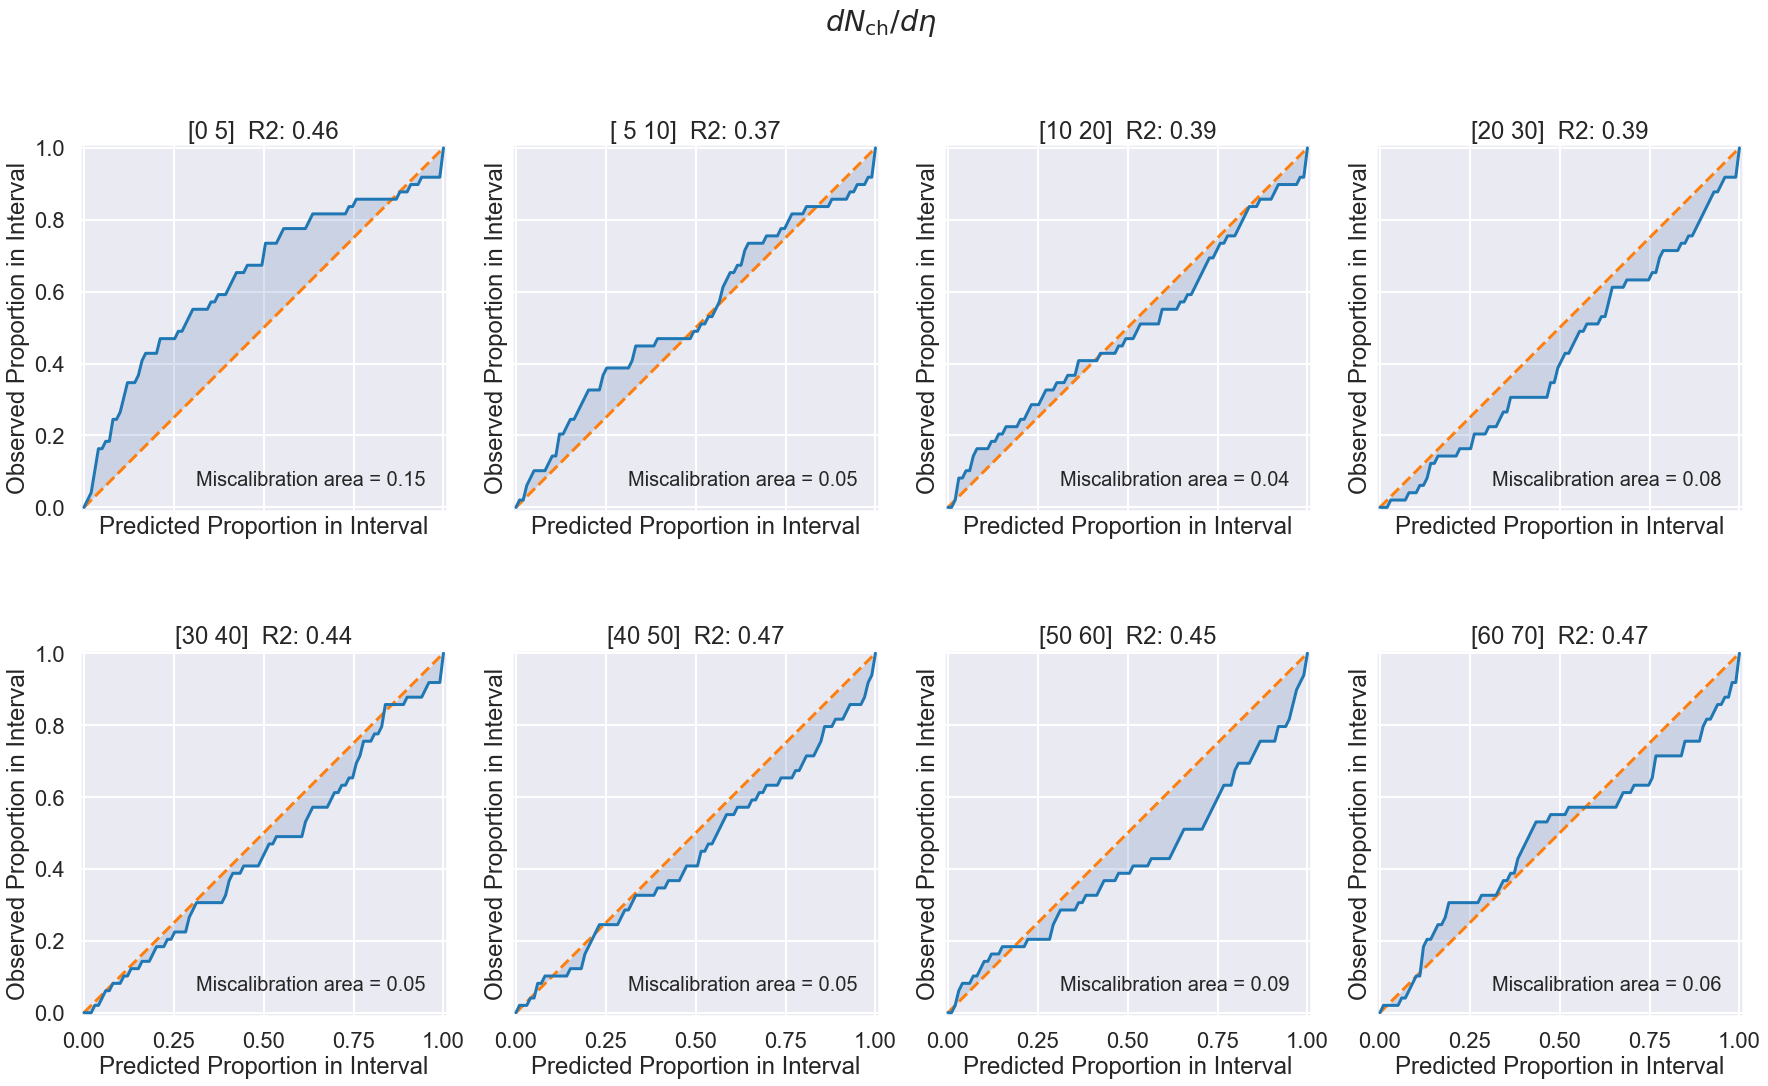

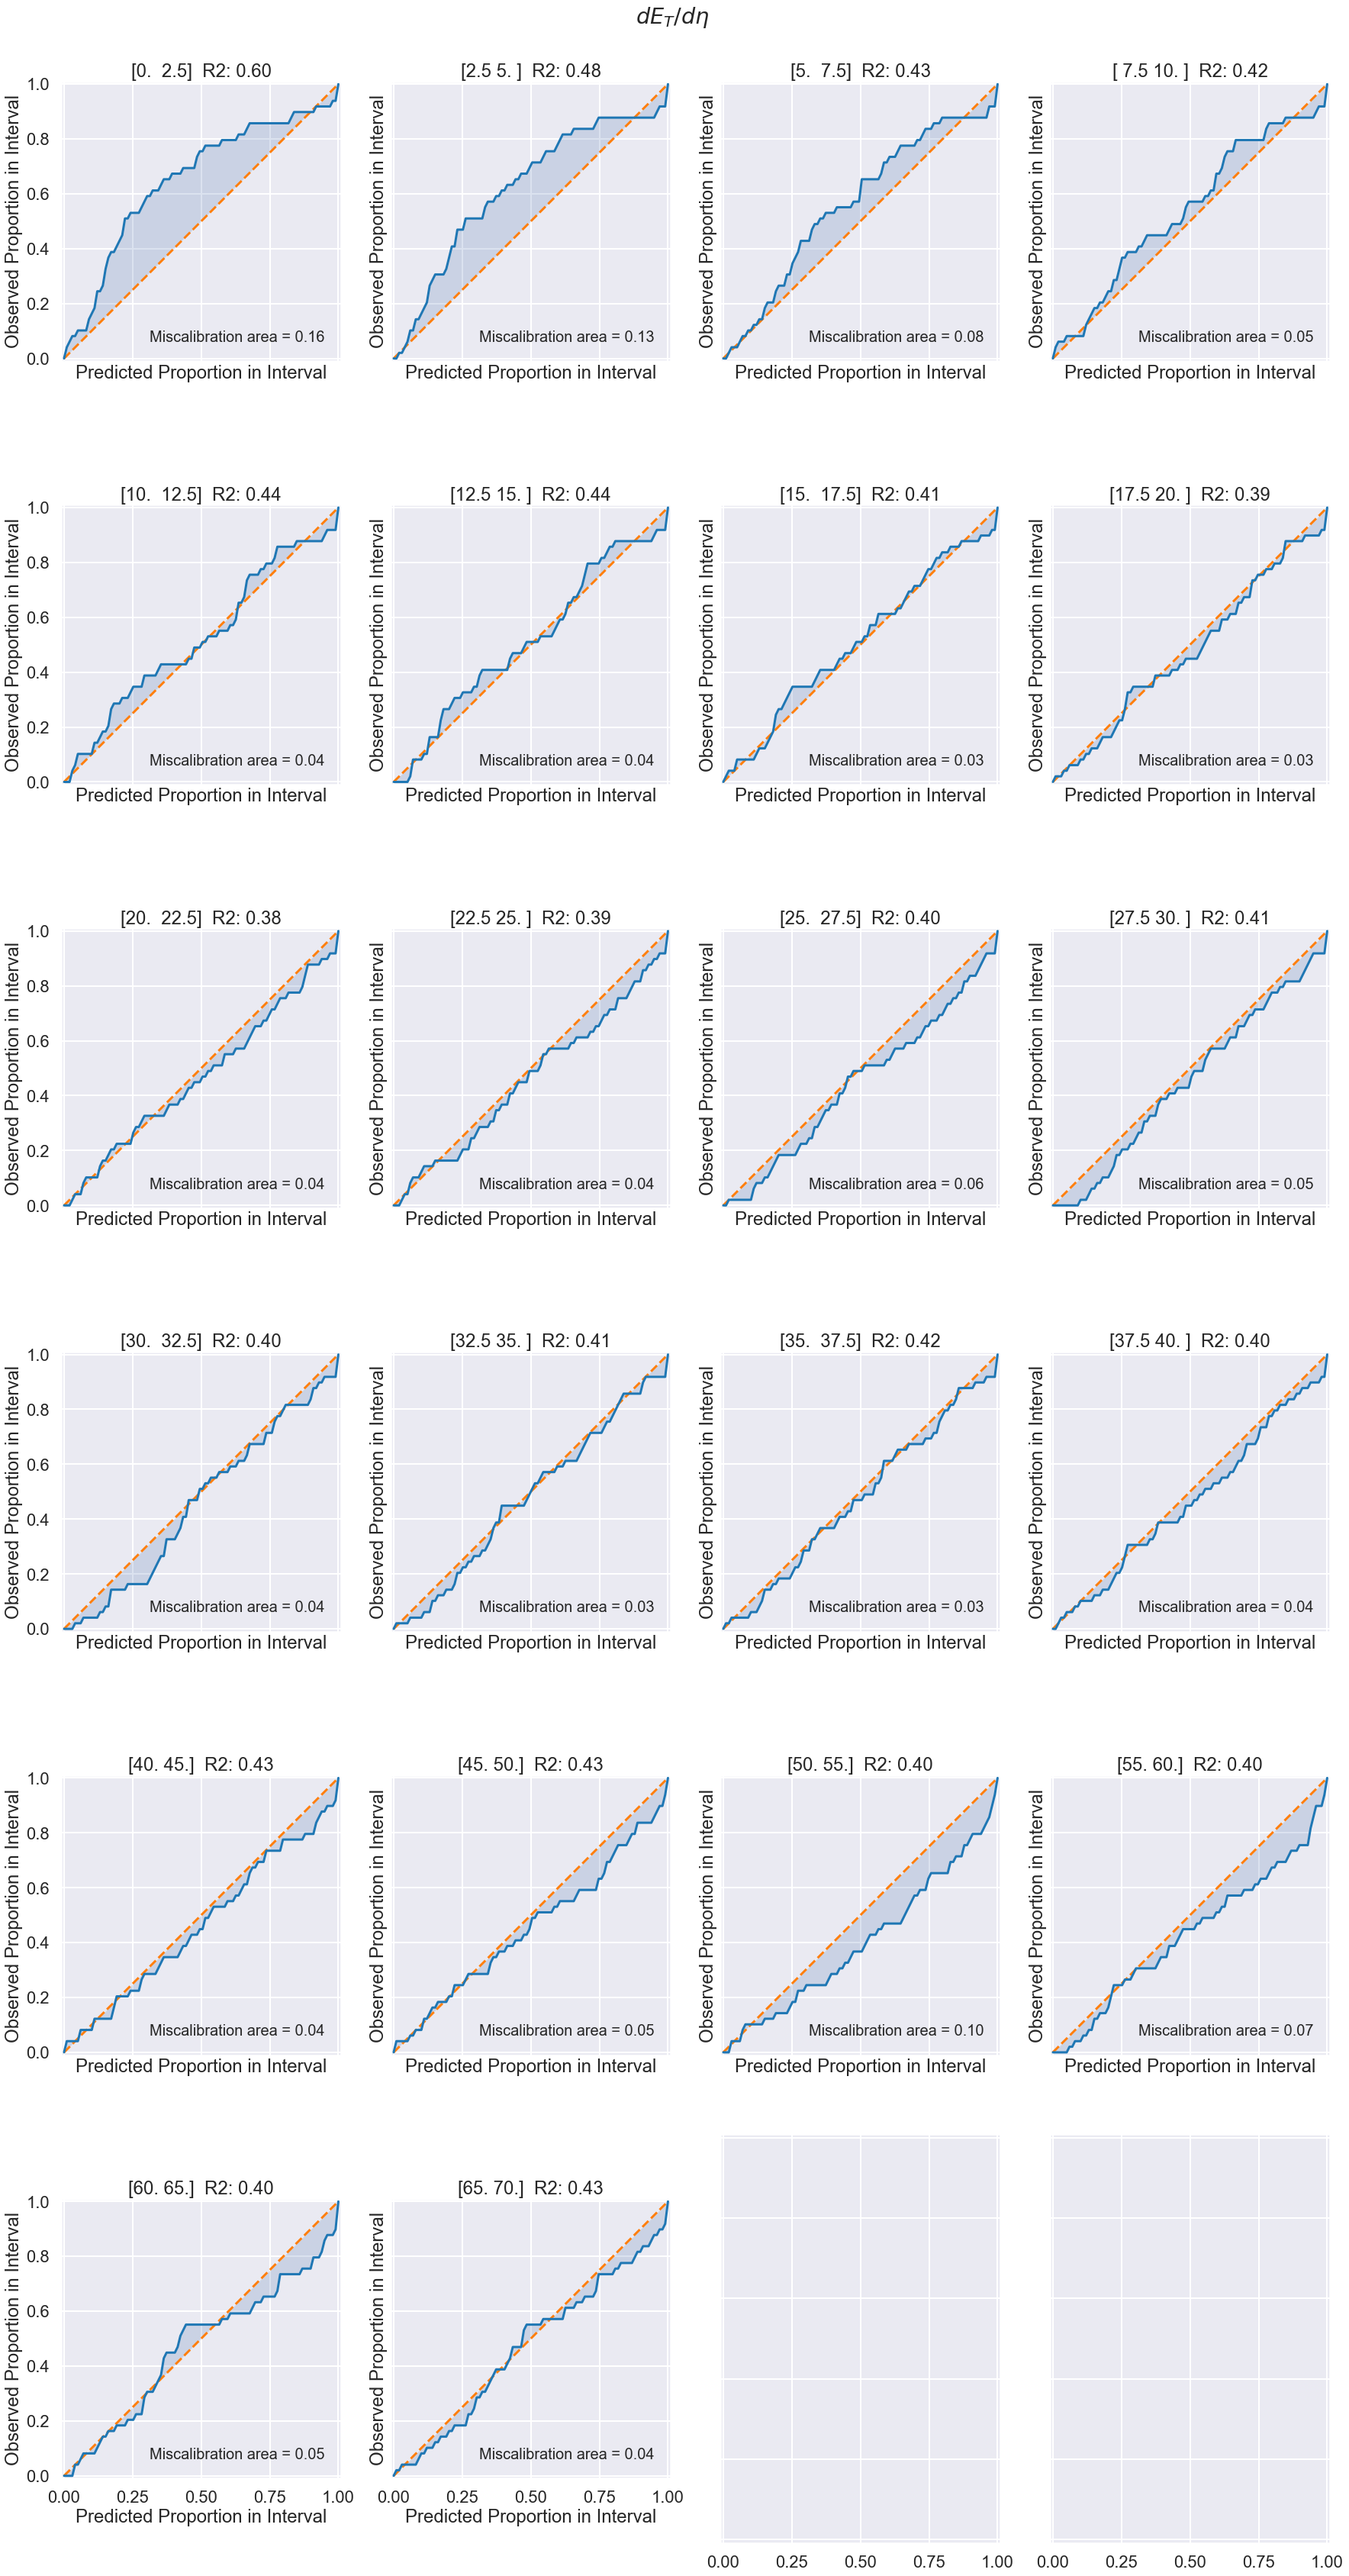

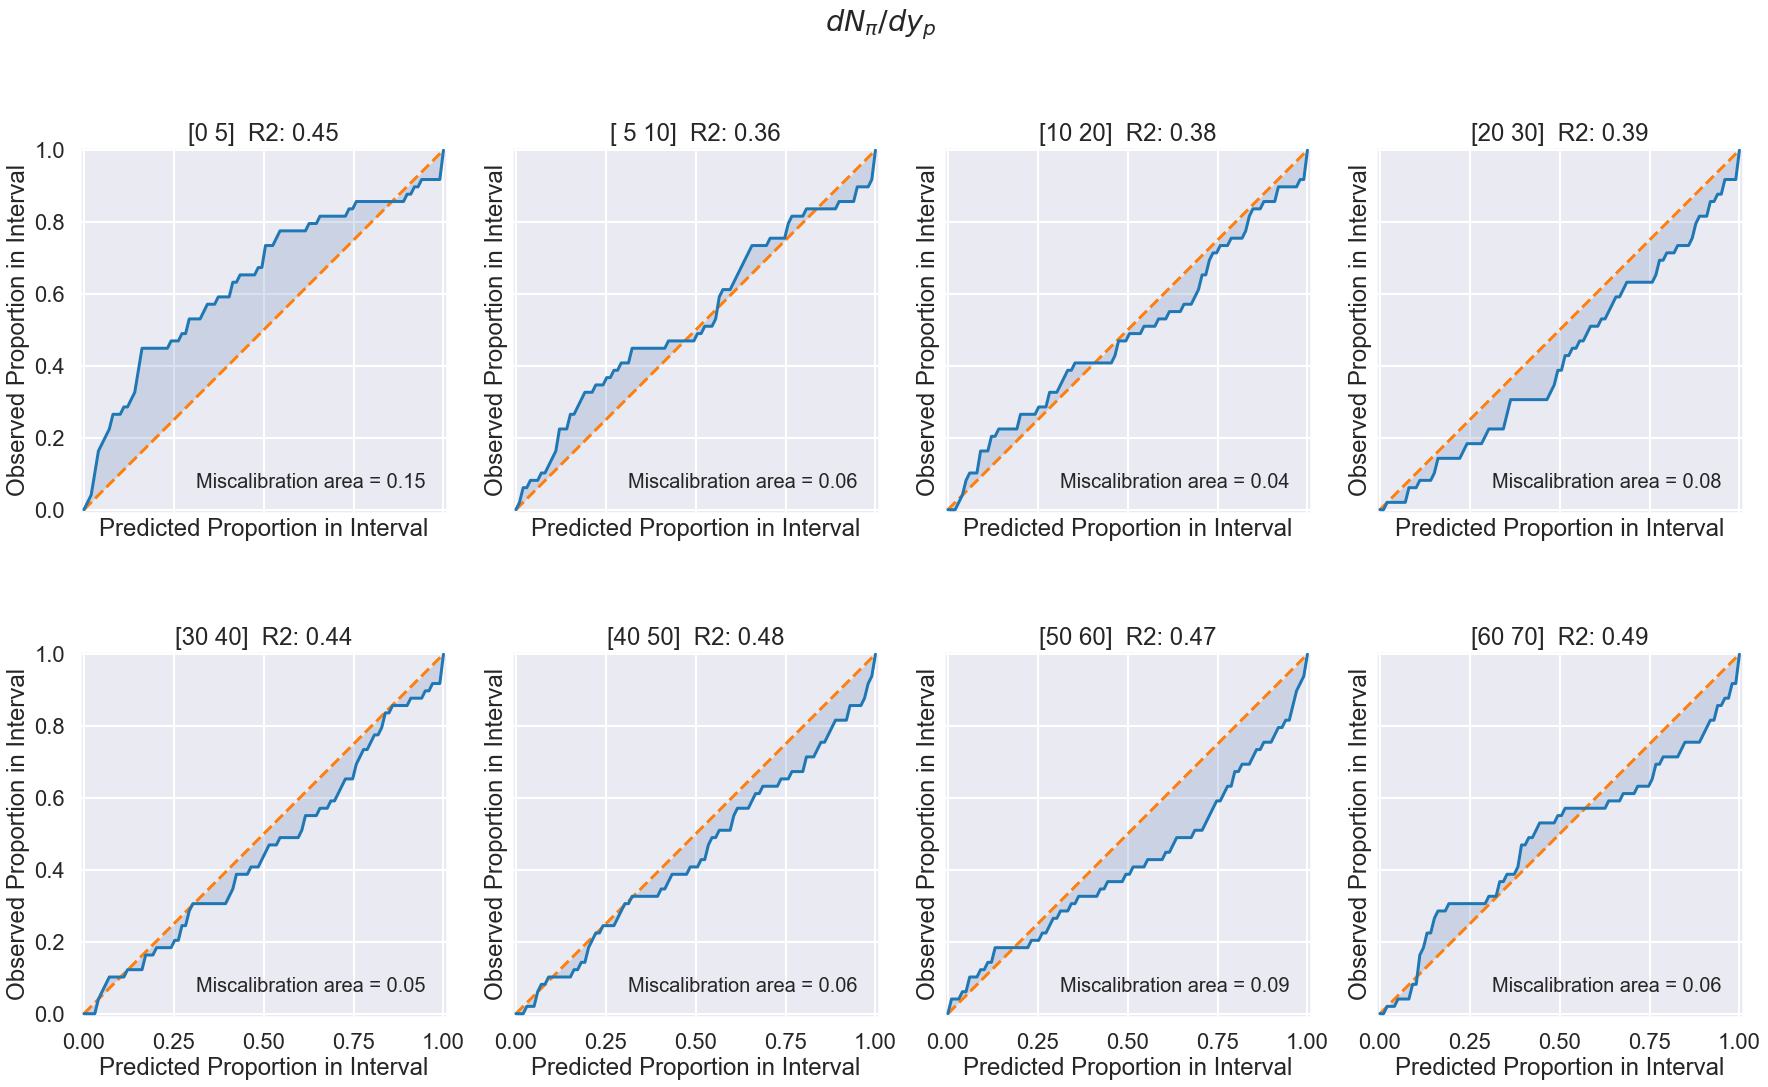

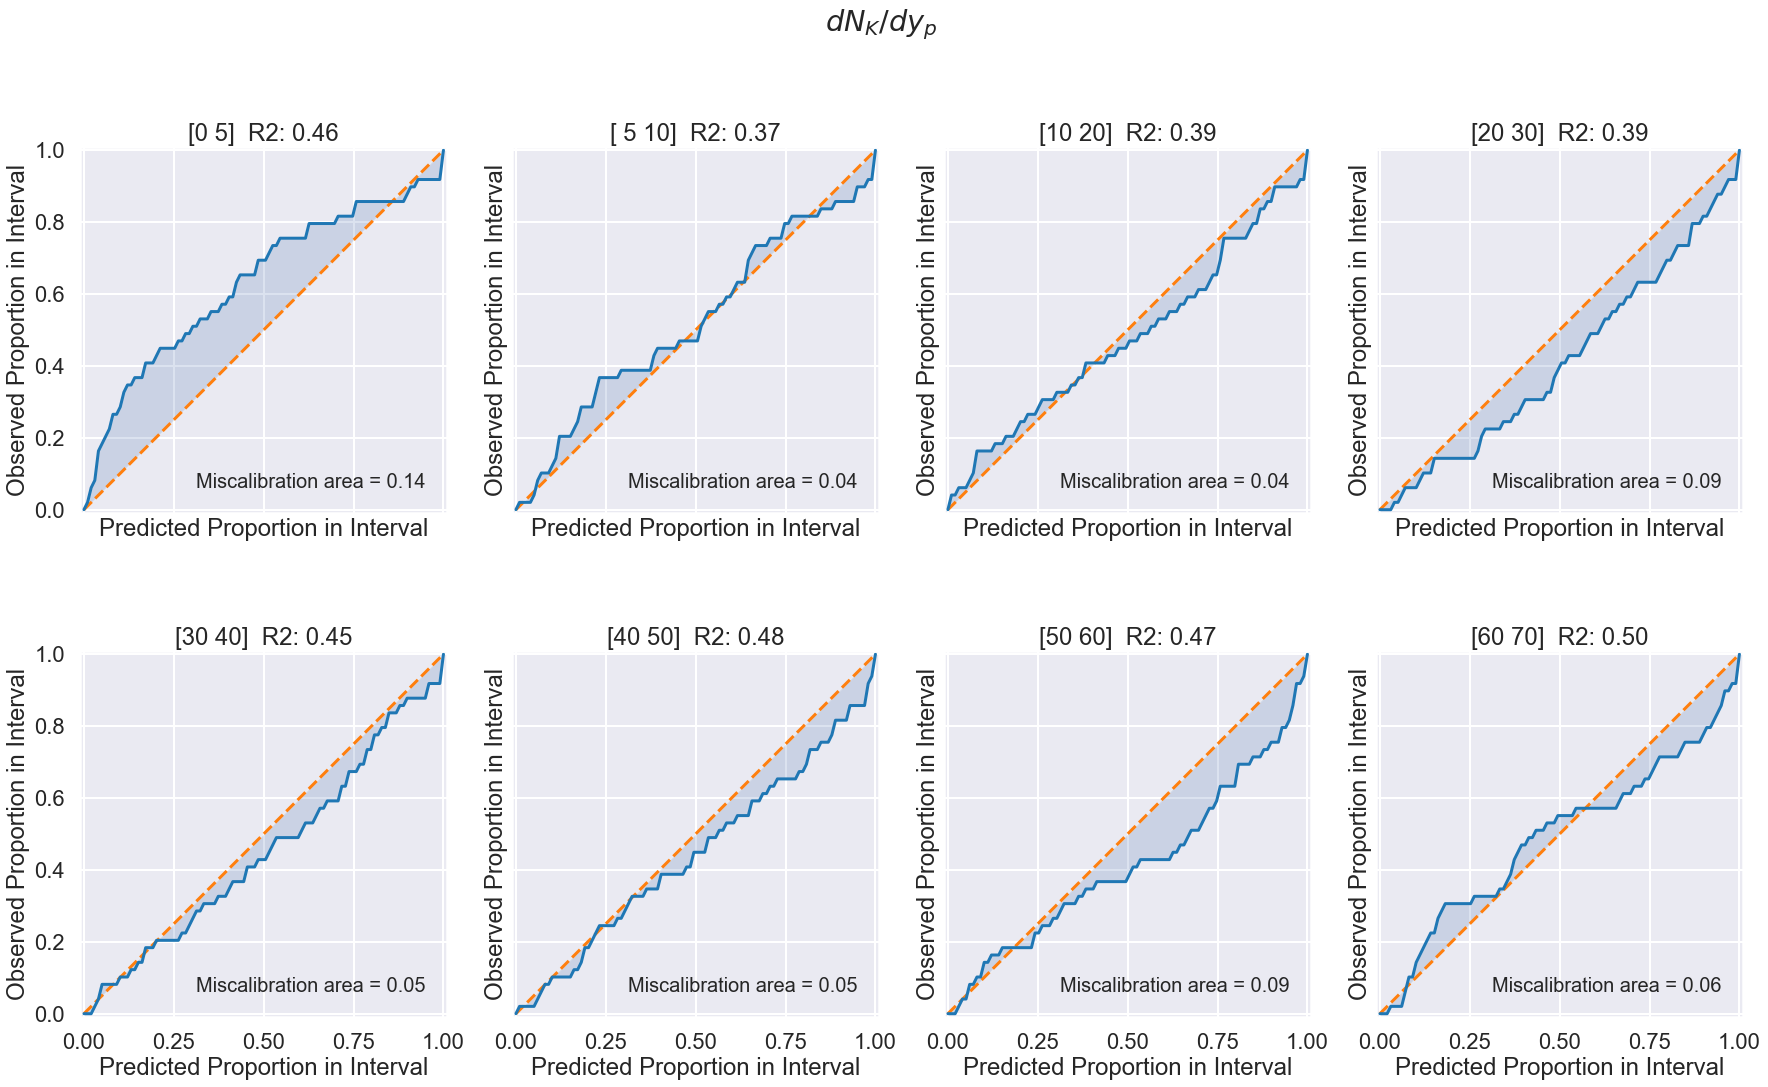

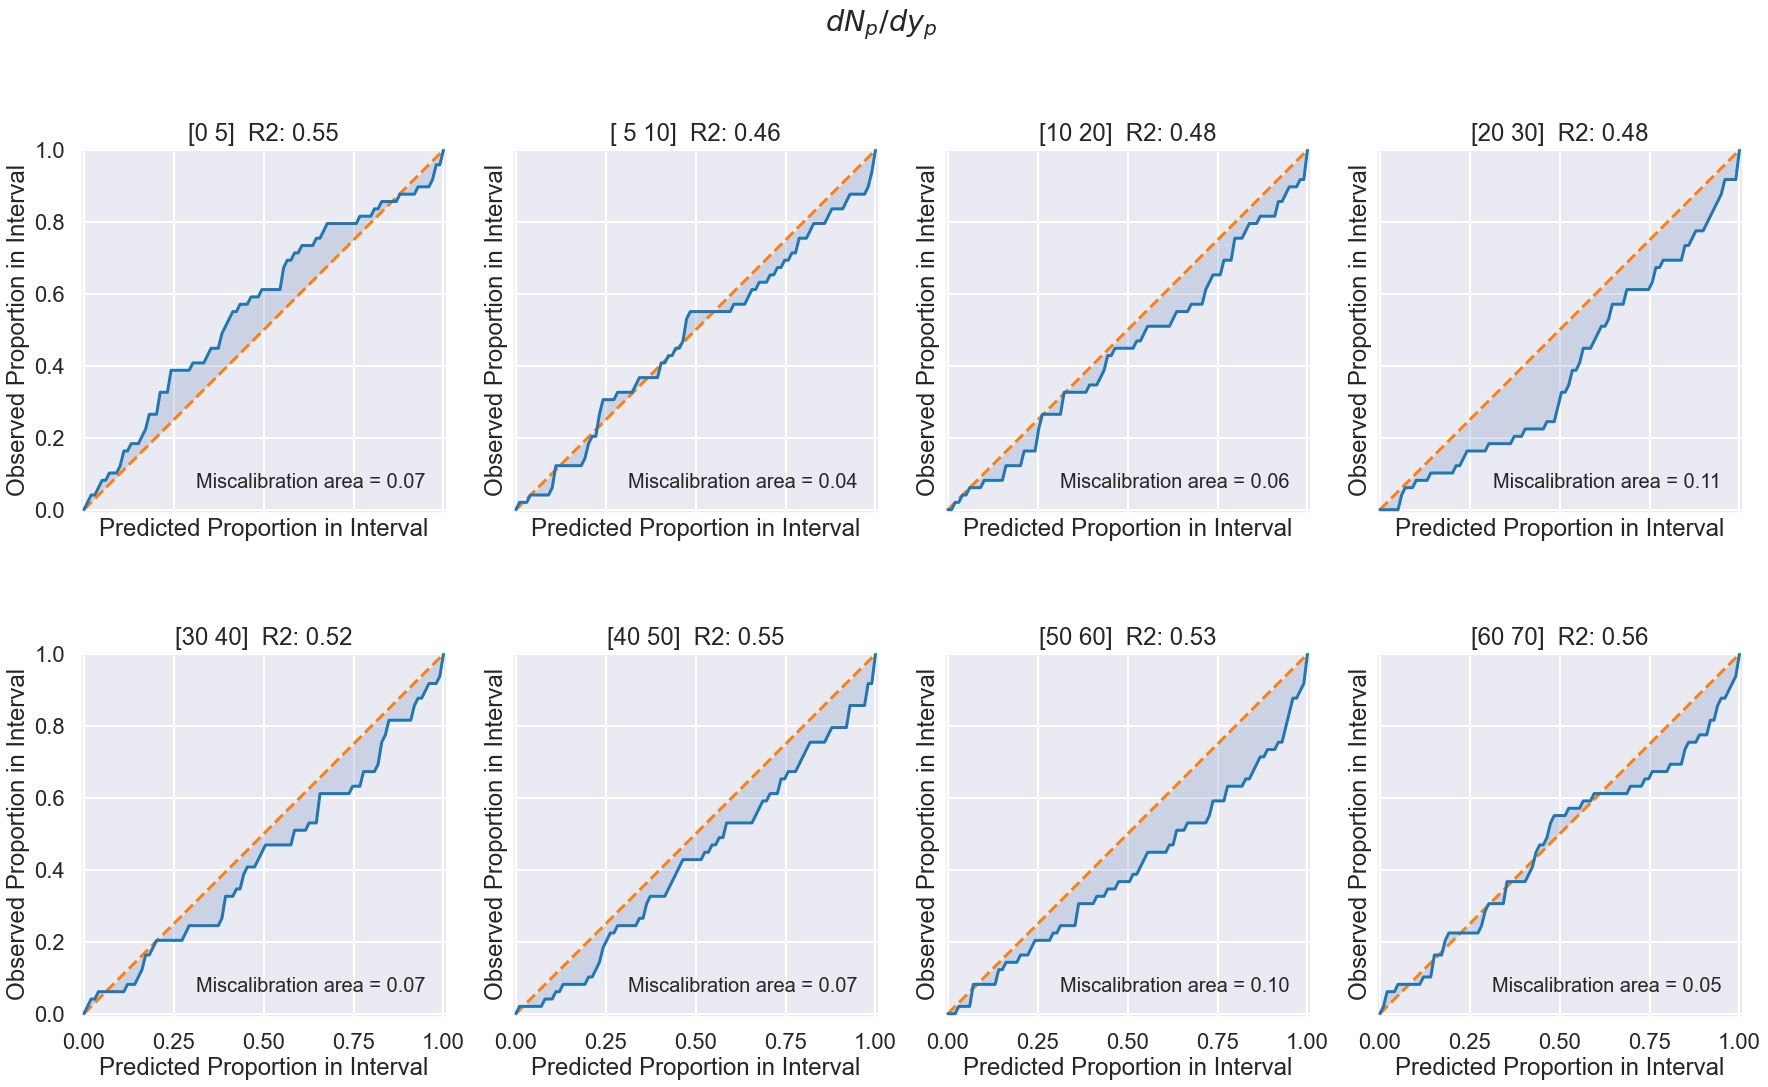

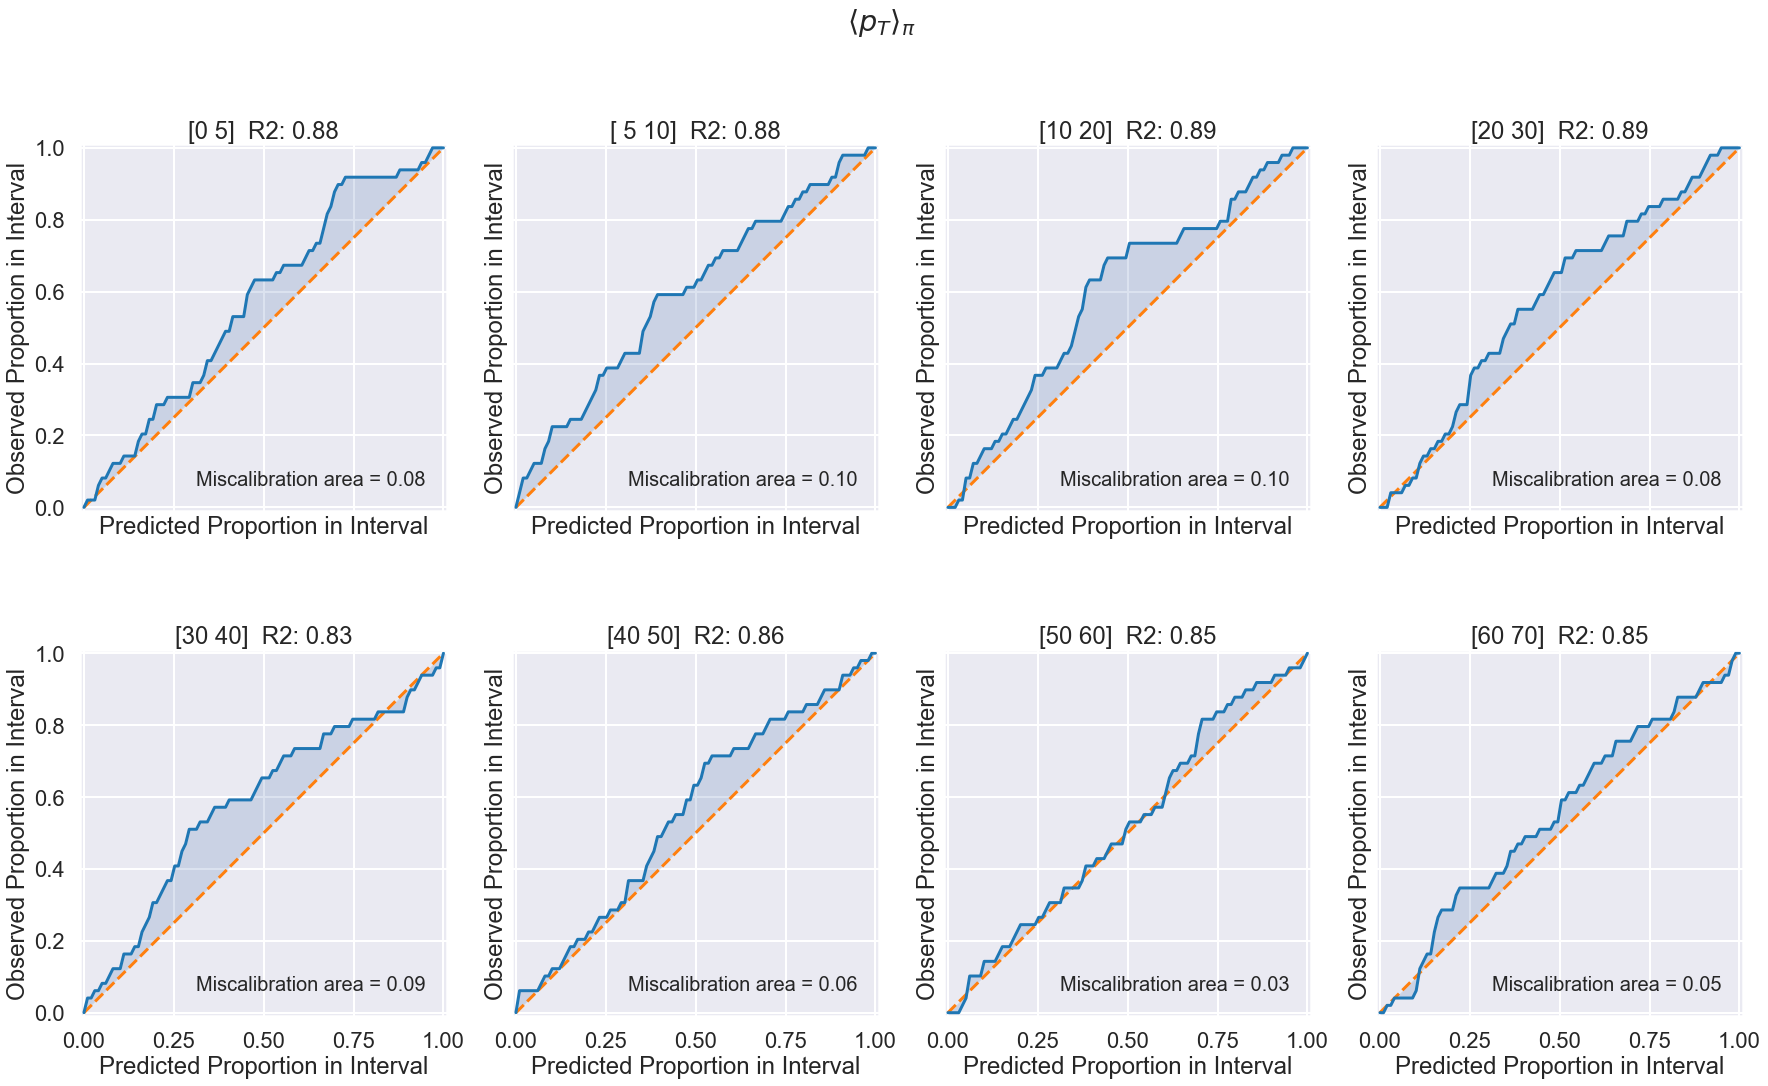

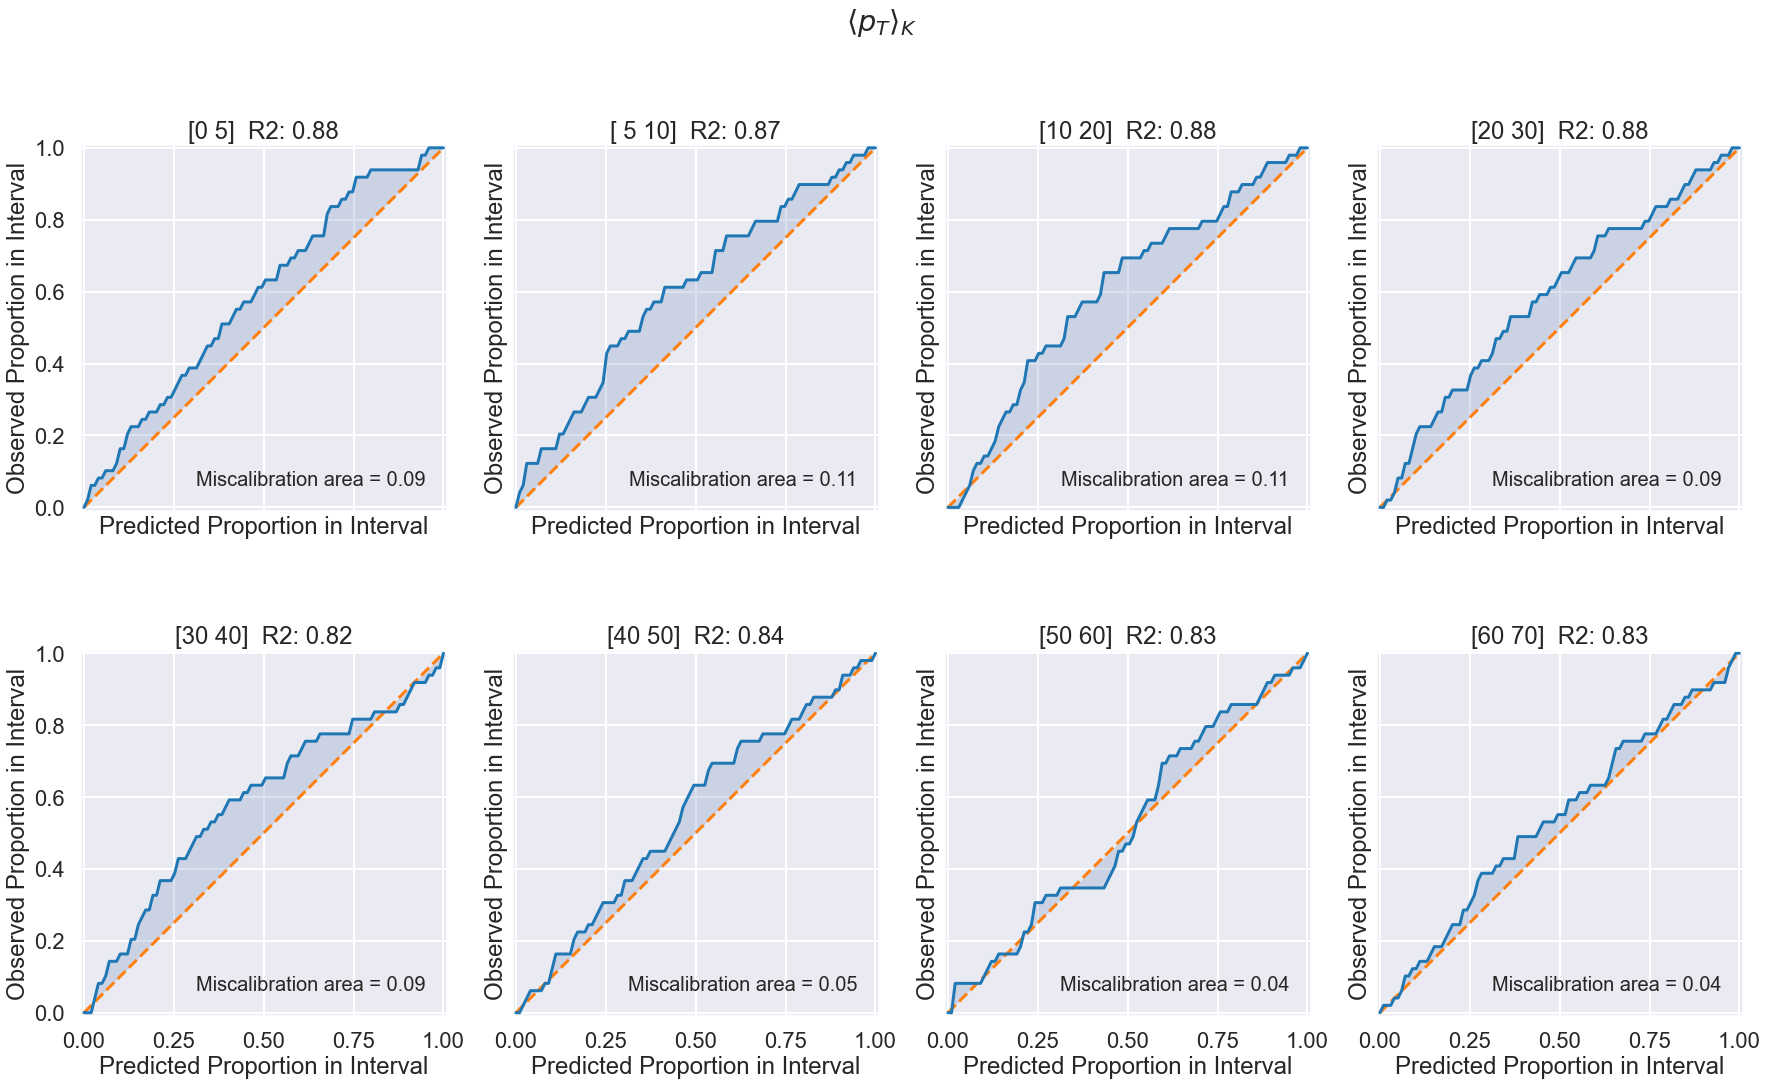

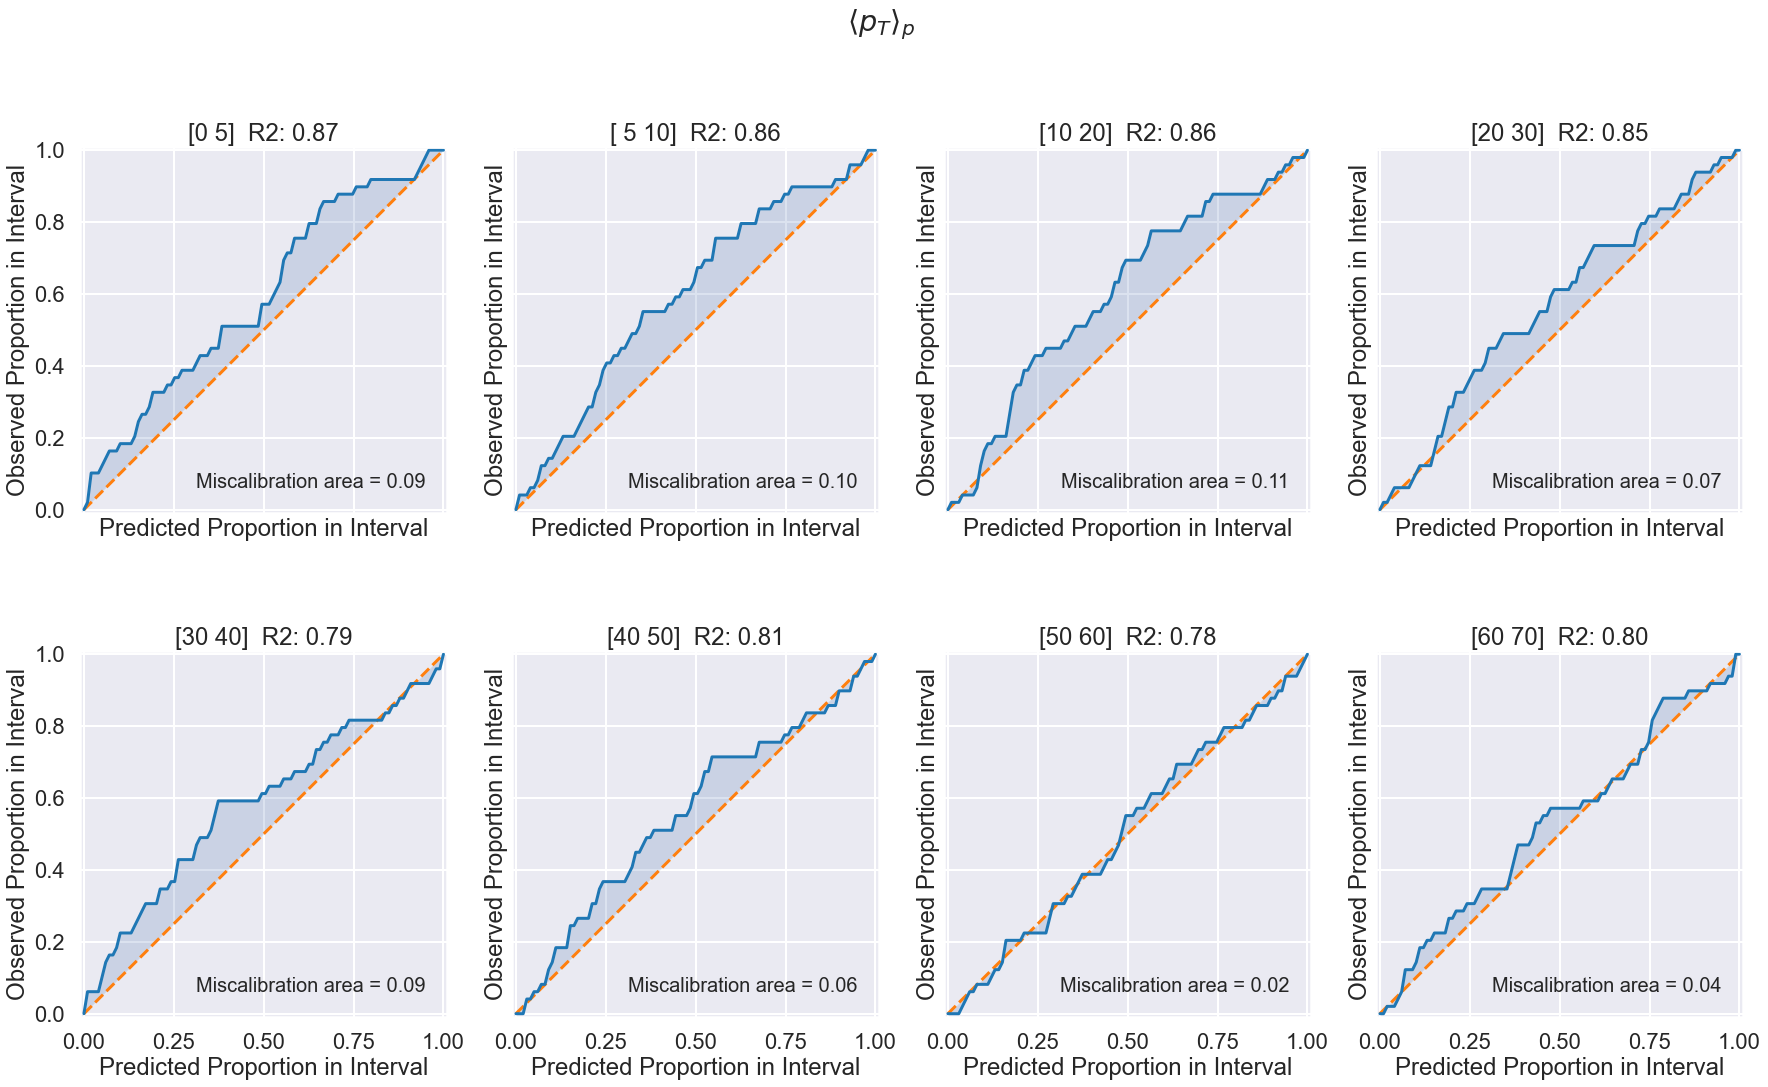

In [54]:
sns.set_context('poster')
for obs in index.keys():
    st = index[obs][0]
    ed = index[obs][1]
    nrw = int(np.ceil((ed-st)/4))
    fig, axs = plt.subplots(nrows=nrw,ncols= 4, figsize=(25,nrw*8),sharex=True, sharey=True)
    for iii,ax in enumerate(axs.flatten()):
        if iii>=ed-st:
            continue;
        ii=st+iii
        mse = sklearn.metrics.mean_squared_error(validation.values[:,ii]\
                                       ,prediction_val[:,ii])
        r = sklearn.metrics.r2_score(validation.values[:,ii]\
                                       ,prediction_val[:,ii])
        #print(r)
        uct.plot_calibration(prediction_val[:,ii], prediction_sig_val[:,ii], validation.values[:,ii], ax=ax)
        #print()
        cen_st = obs_cent_list['Pb-Pb-2760'][obs][iii]
        #print(cen_st)
        ax.set_title(f'{cen_st}  R2: {r:.2f}')
    fig.suptitle(obs_tex_labels[obs])
    plt.tight_layout()
    #save_fig(f'vah_50_{obs}_calibration_curve.png')

In [55]:
import scipy.stats as stat

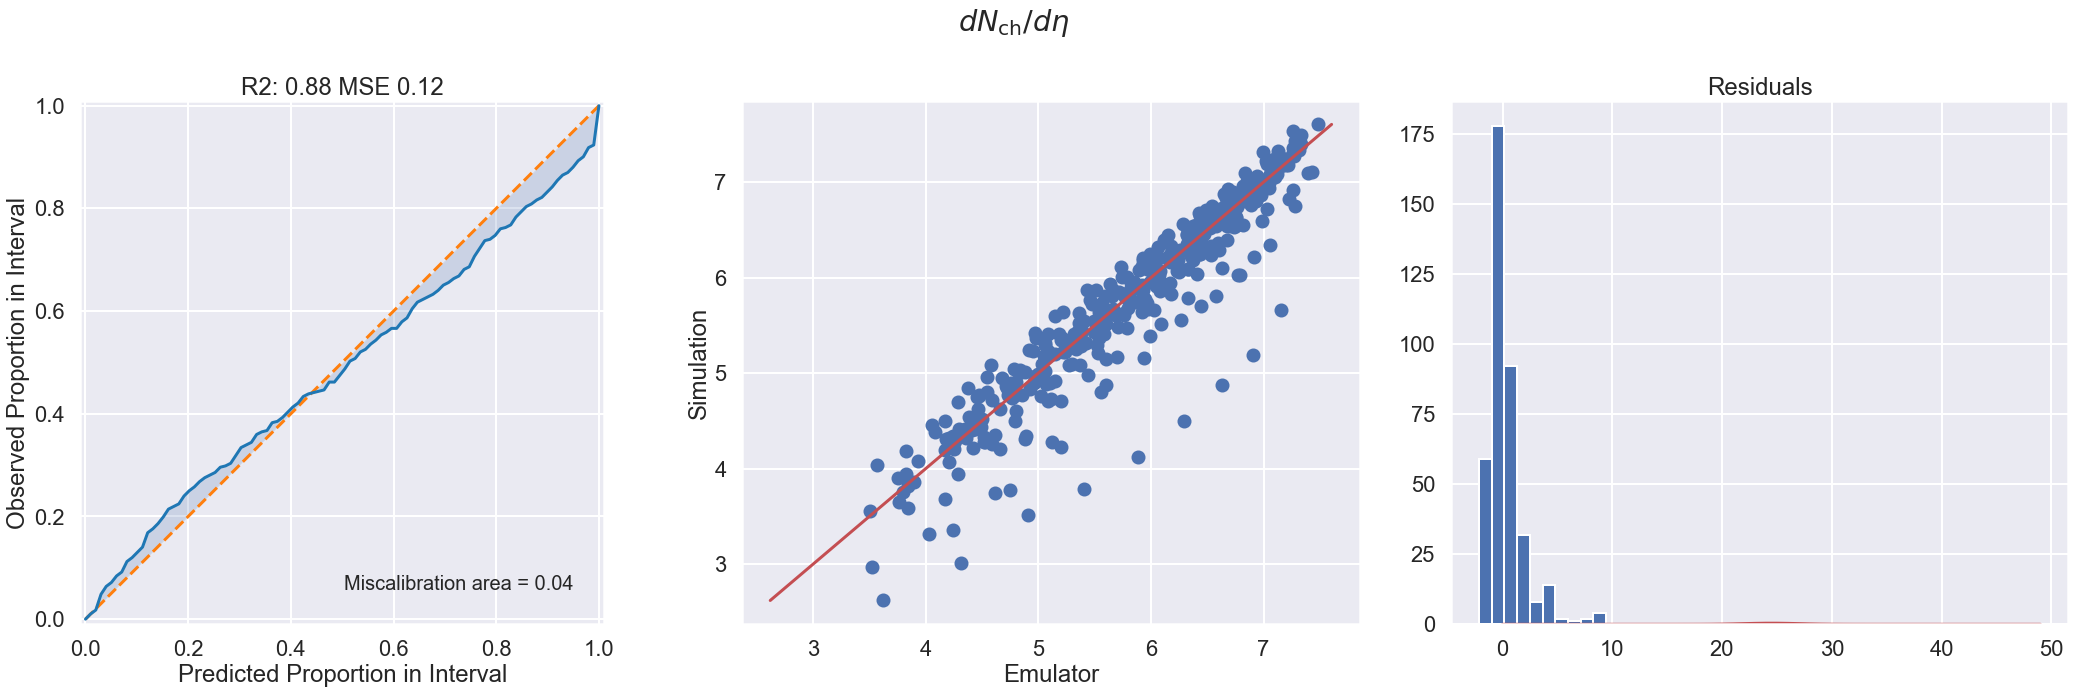

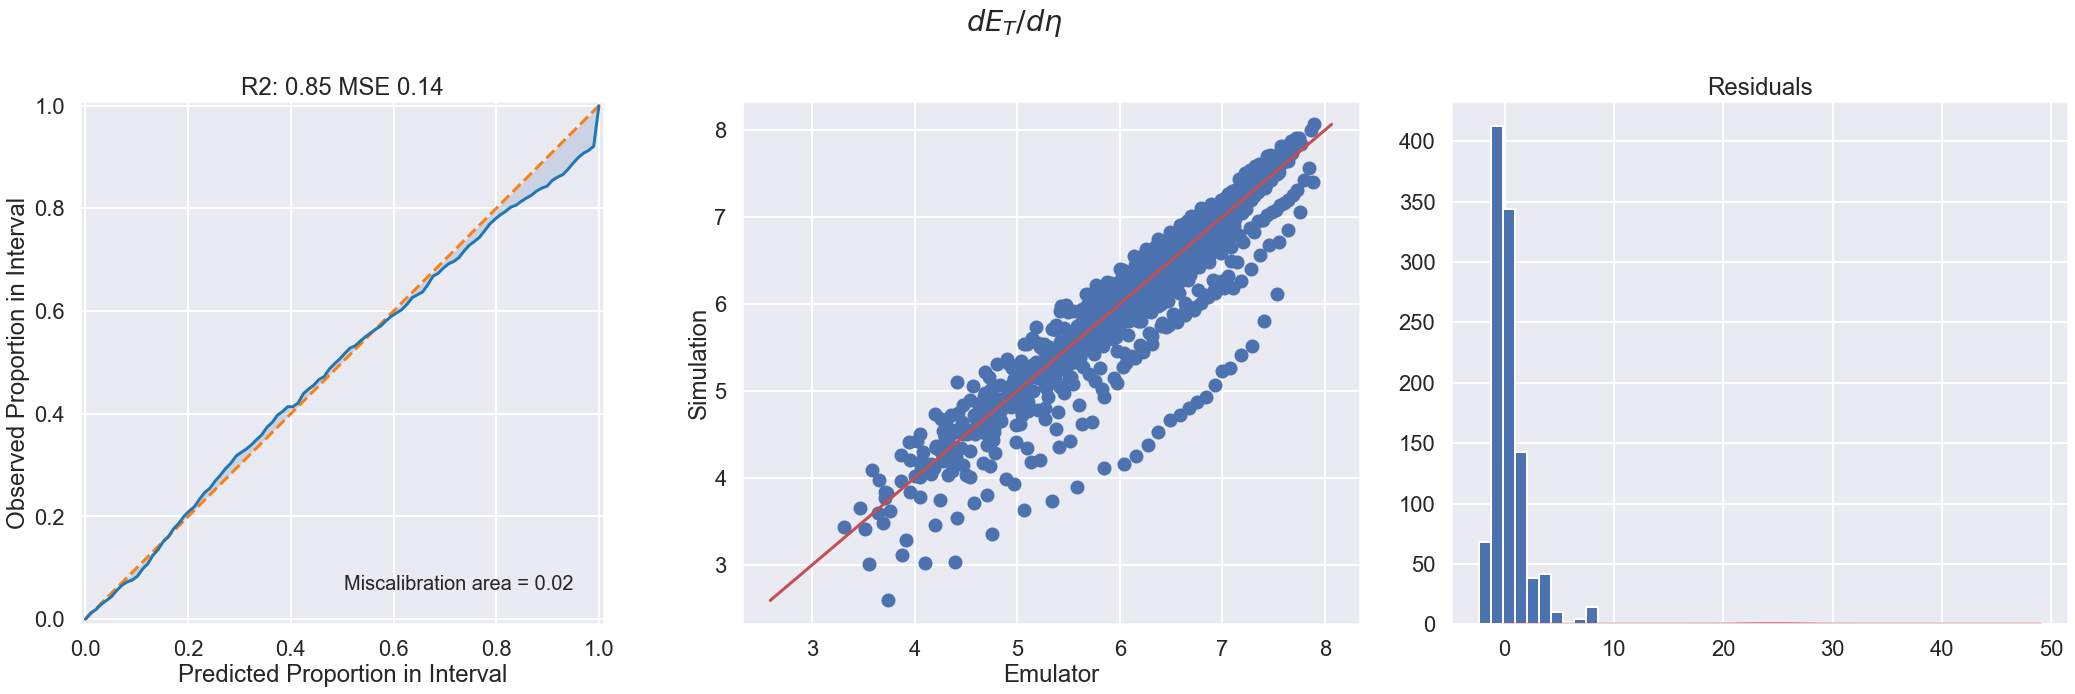

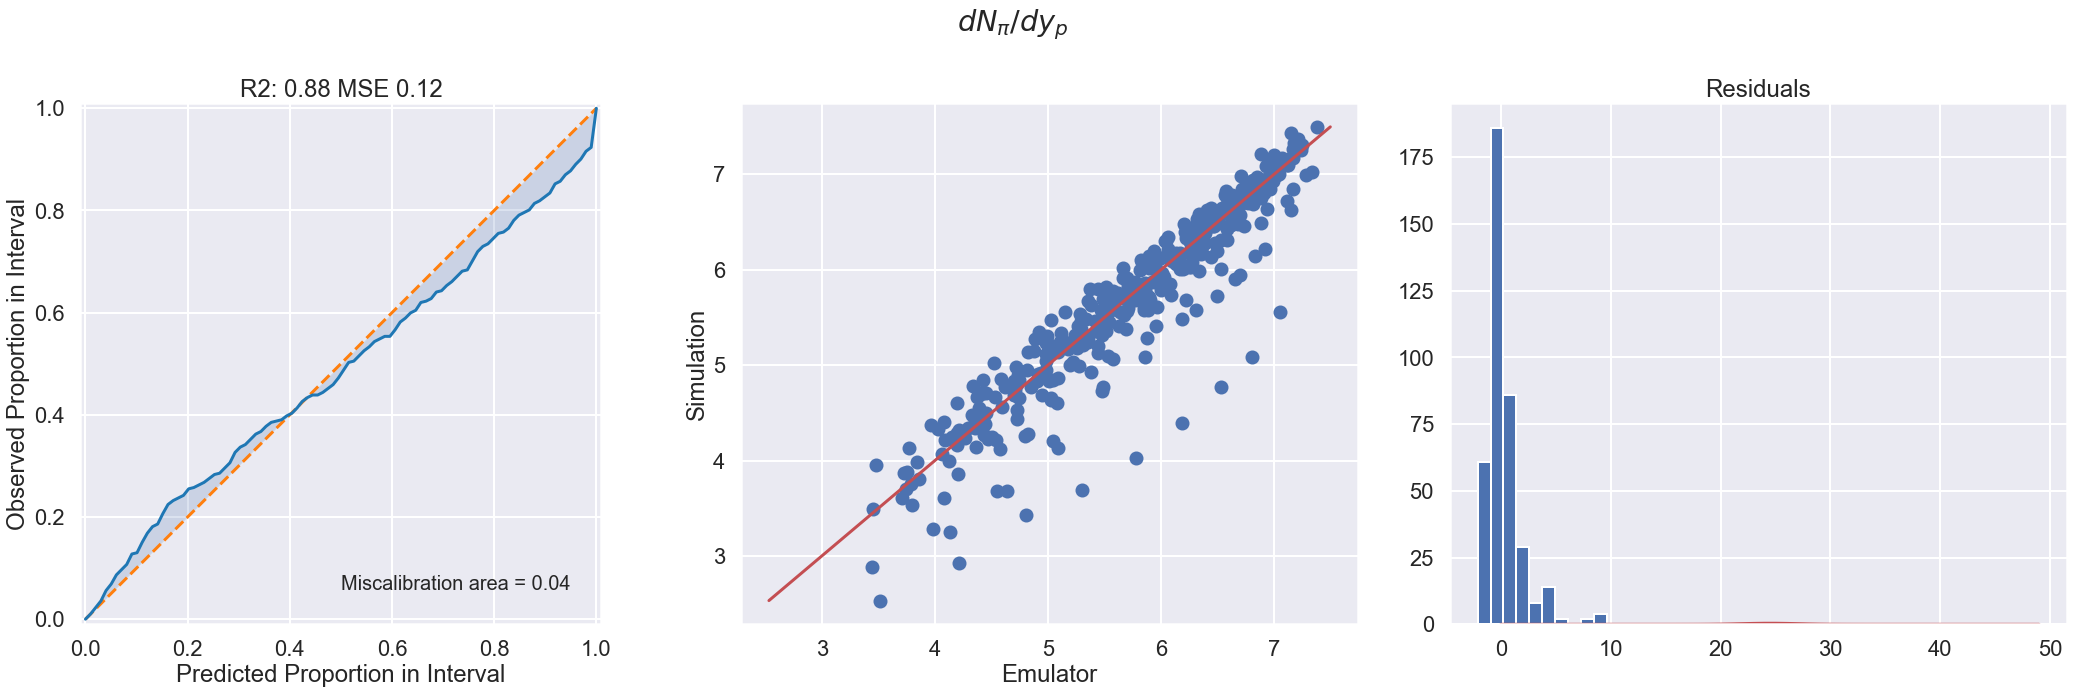

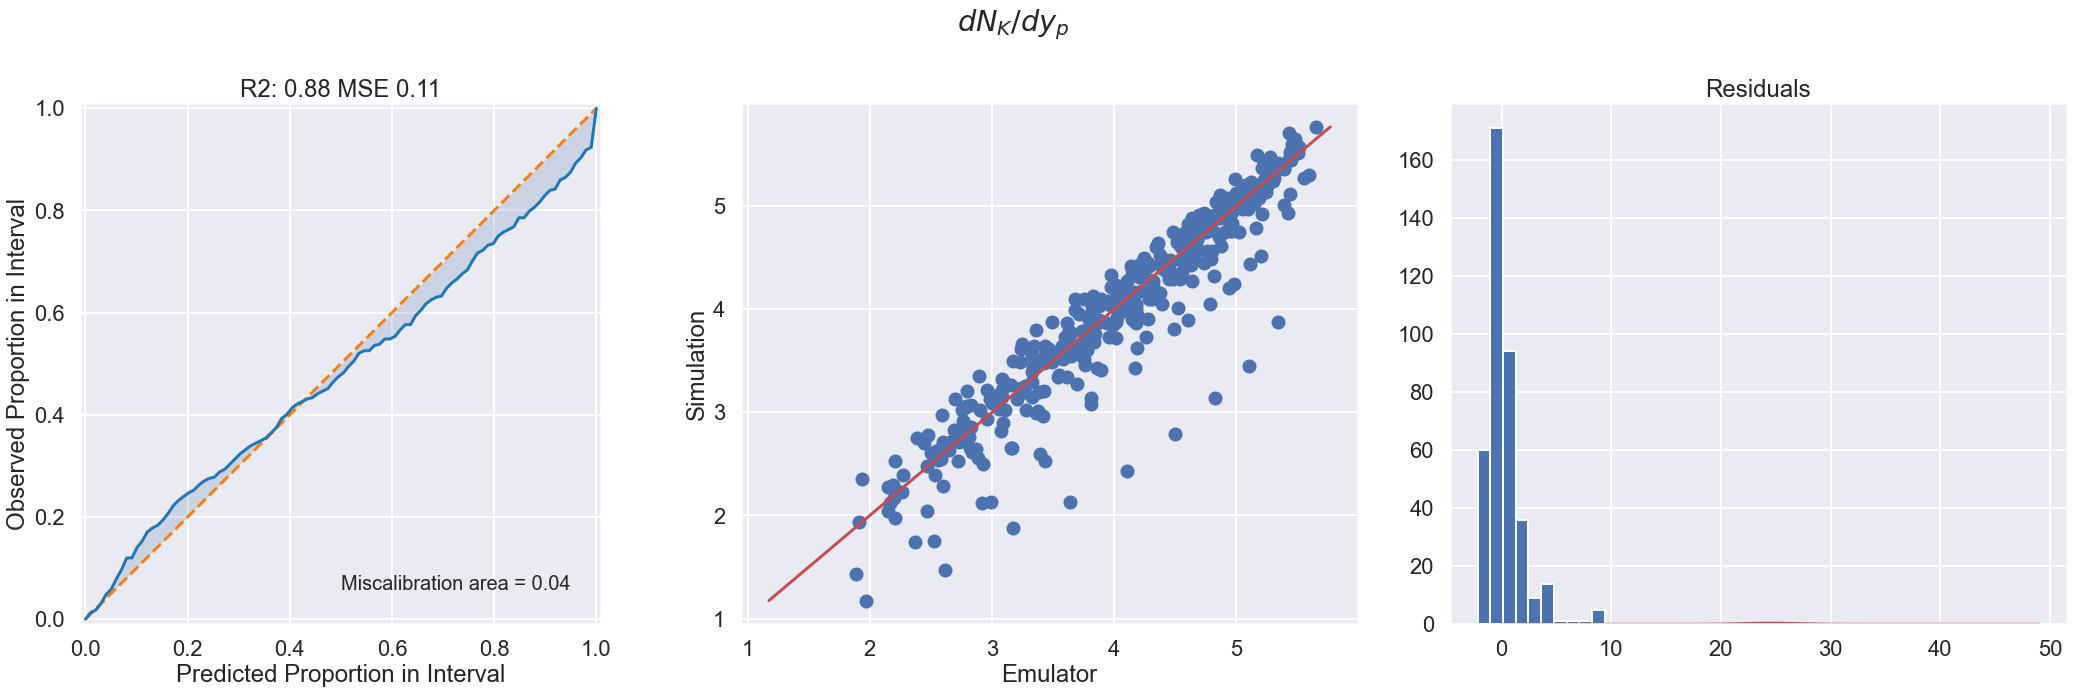

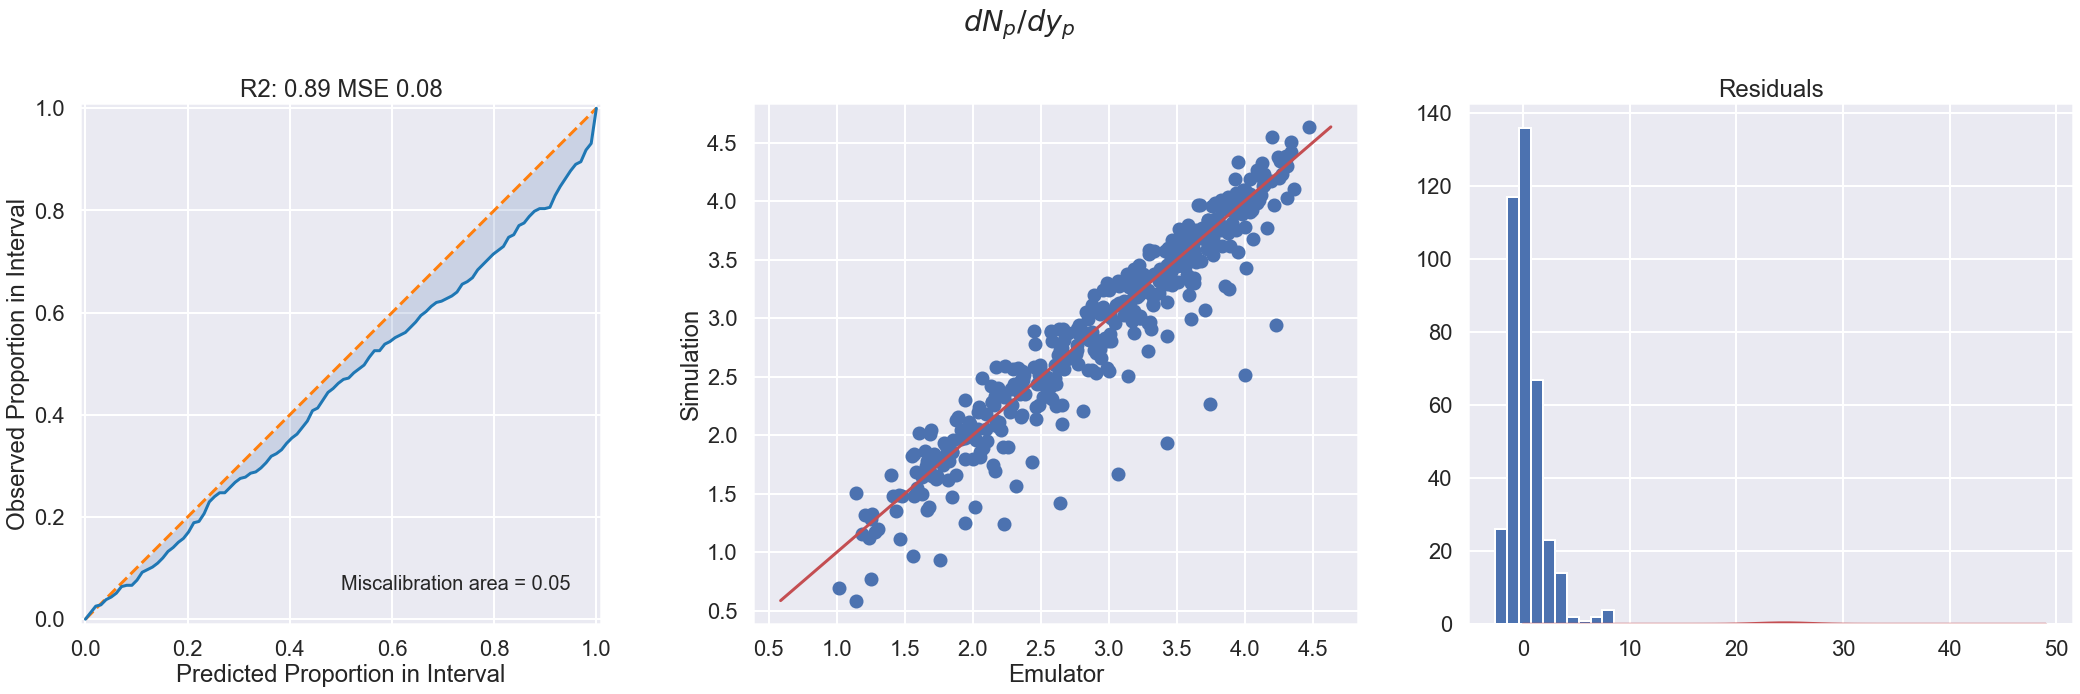

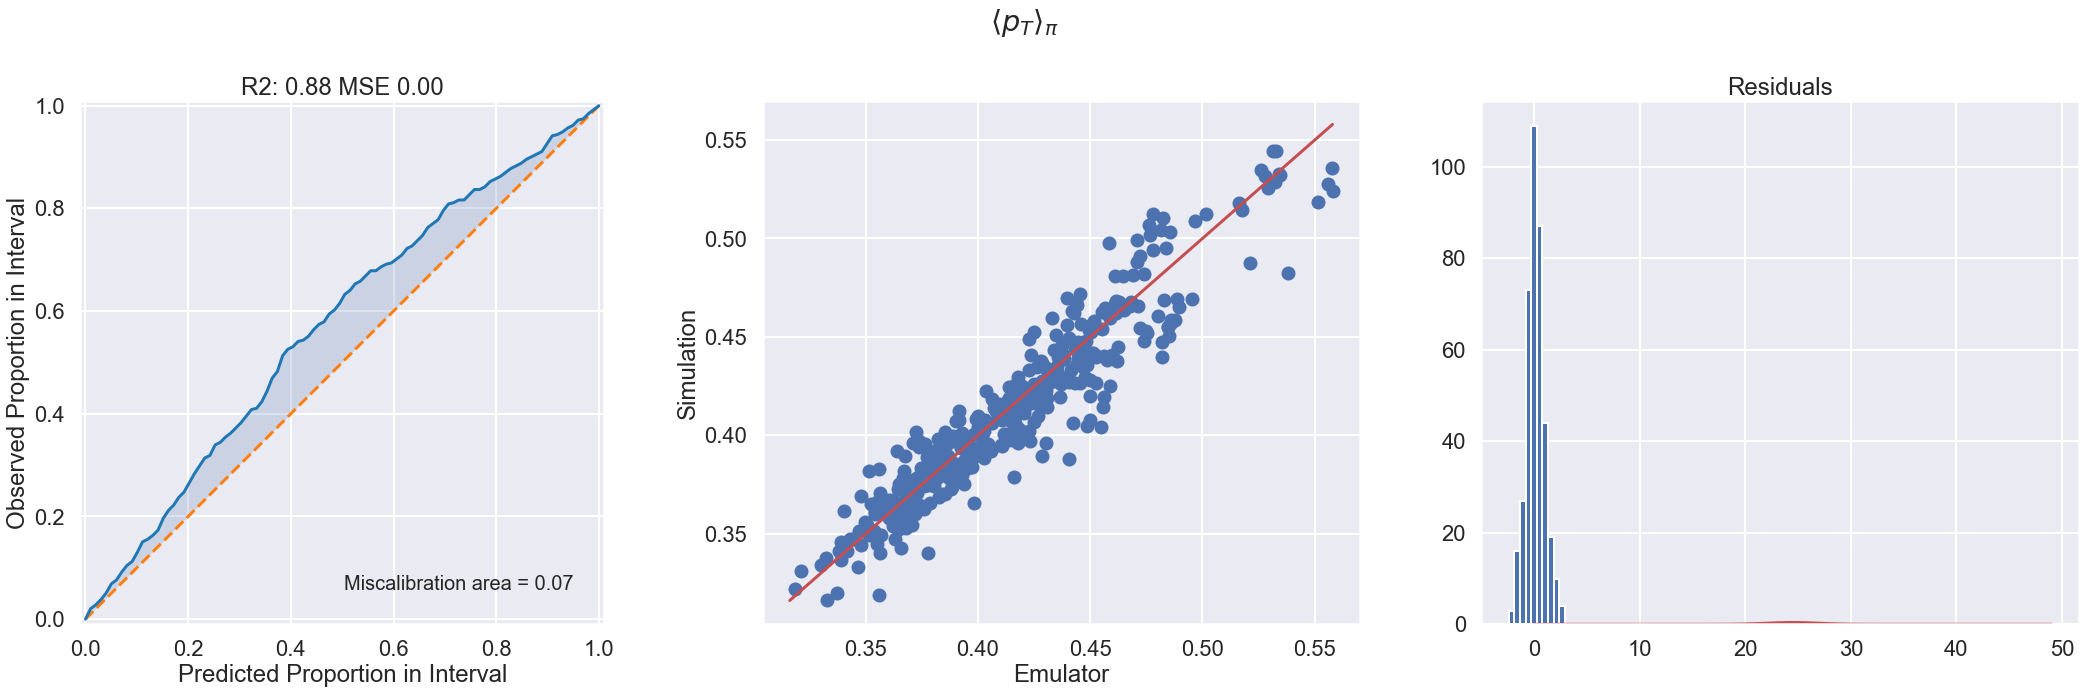

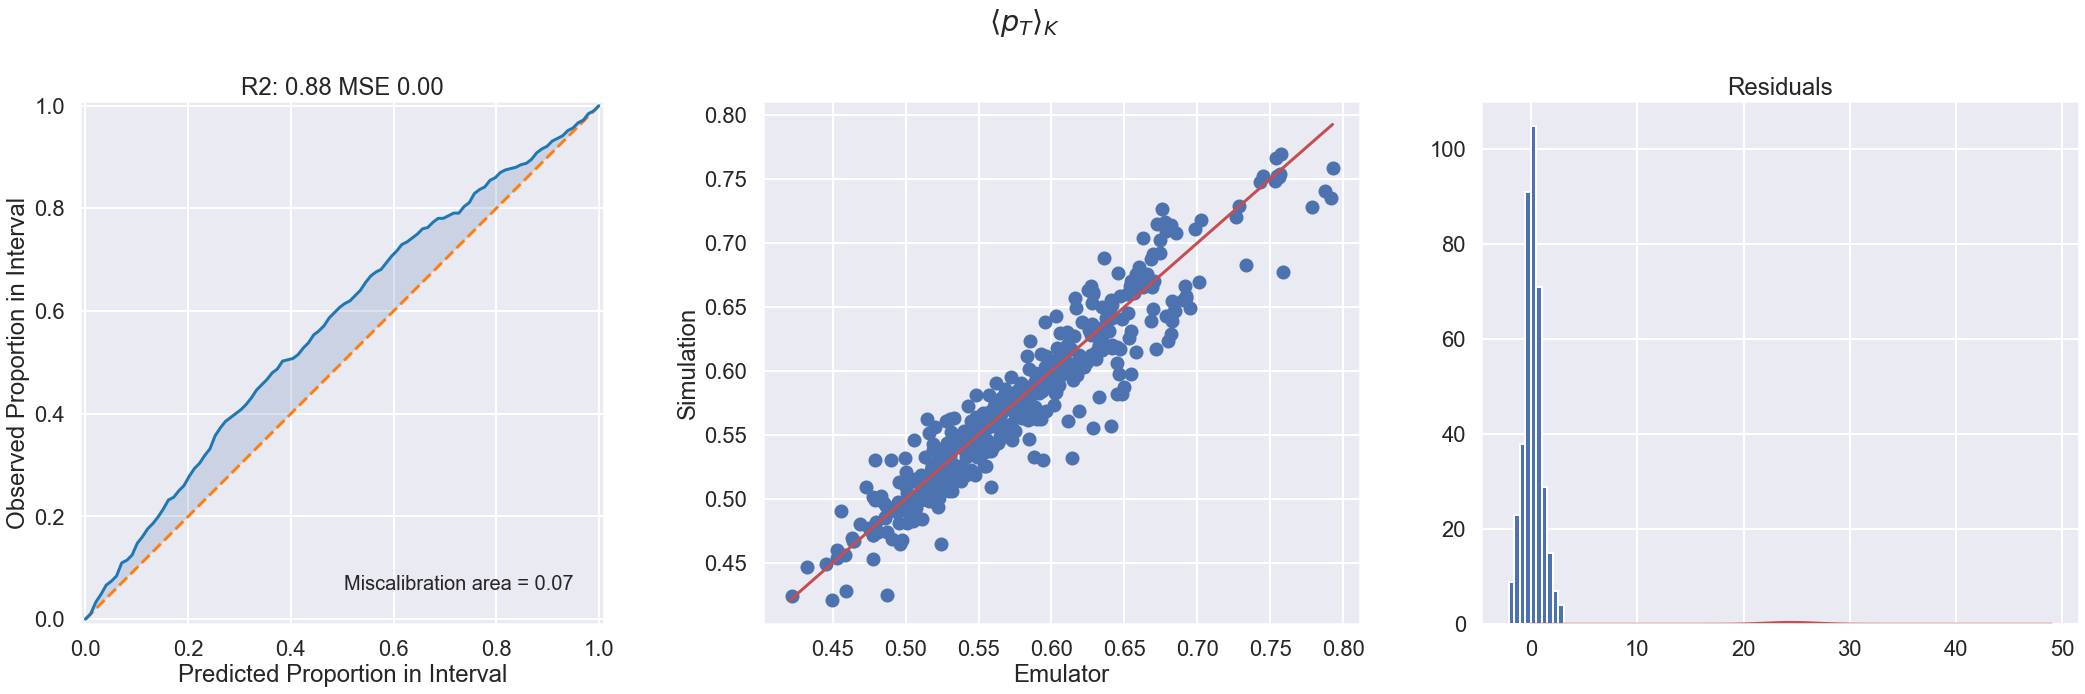

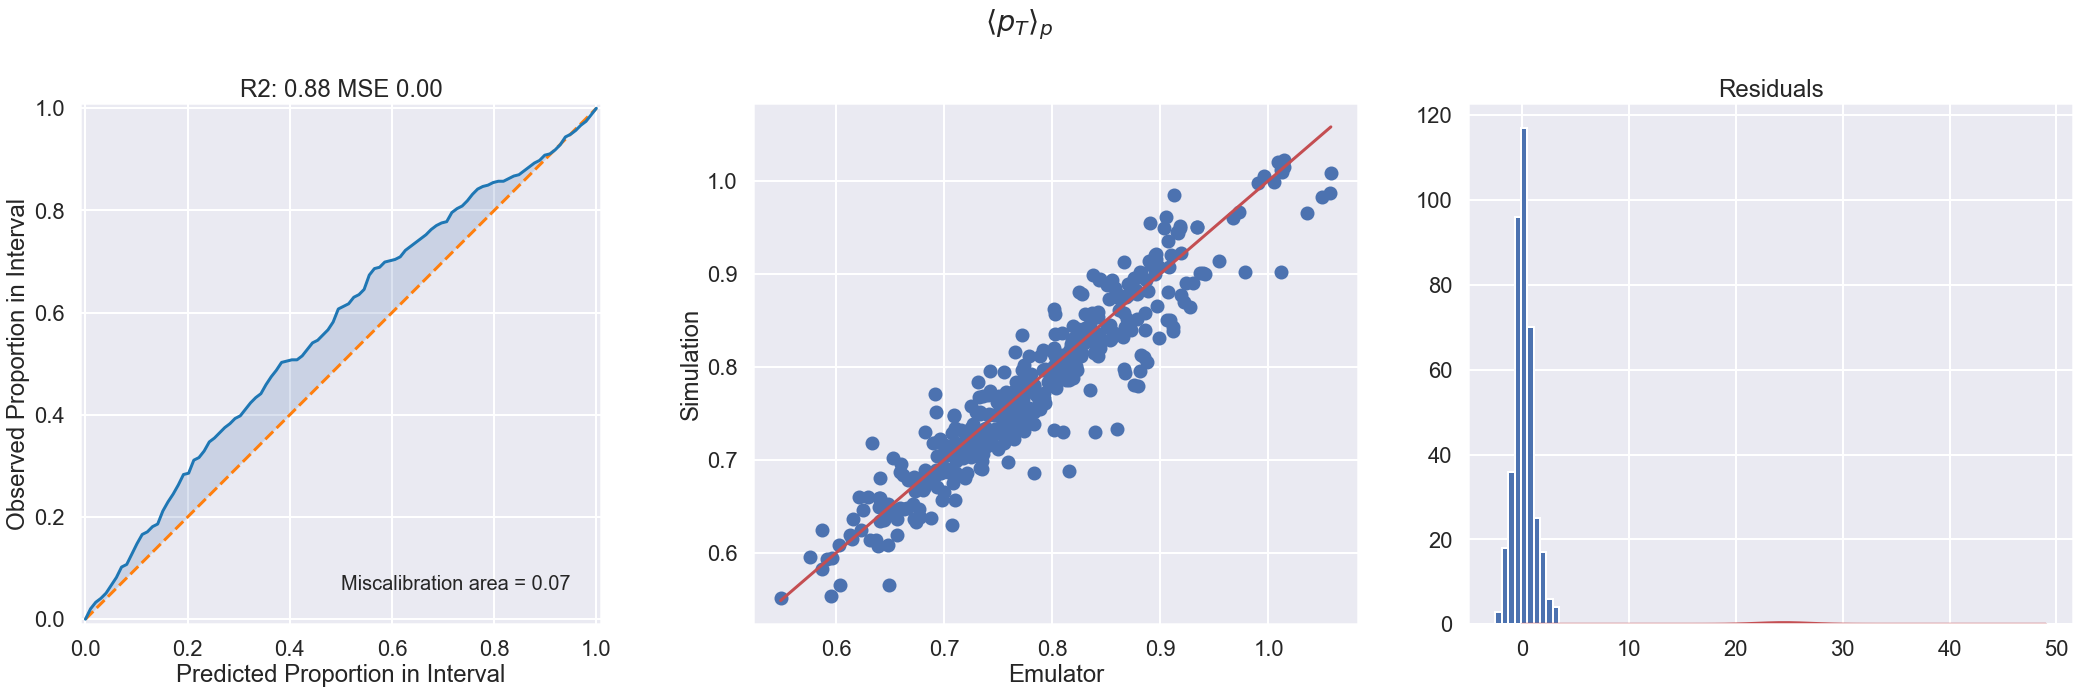

In [56]:
sns.set_context('poster')
for obs in index.keys():
    st = index[obs][0]
    ed = index[obs][1]
    #nrw = int(np.ceil((ed-st)/4))
    fig, axs = plt.subplots(nrows=1,ncols= 3, figsize=(30,10),sharex=False, sharey=False)
    prediction = prediction_val[:,st:ed].flatten()
    prediction_sd = prediction_sig_val[:,st:ed].flatten()
    validation_tmp = validation.values[:,st:ed].flatten()
    uct.plot_calibration(prediction, 
                         prediction_sd, 
                         validation_tmp, ax=axs[0])
    
    mse = sklearn.metrics.mean_squared_error(validation_tmp\
                                    ,prediction)
    r = sklearn.metrics.r2_score(validation_tmp\
                                    ,prediction)
    axs[0].set_title(f'R2: {r:.2f} MSE {mse:.2f}')
    
    axs[1].scatter(prediction, validation_tmp)
    maxx = np.maximum(prediction,validation_tmp)
    minx = np.minimum(prediction,validation_tmp)


    
    axs[1].plot([np.min(minx),np.max(maxx)]
                ,[np.min(minx),np.max(maxx)]
                ,color='r')
    axs[1].set_xlabel('Emulator')
    axs[1].set_ylabel('Simulation')
    residual = np.divide((prediction - validation_tmp),prediction_sd)
    
    axs[2].hist(residual)
    x_tmp = np.linspace(-10,10)
    axs[2].plot(stat.norm.pdf(x_tmp), color='r')
    axs[2].set_title('Residuals')
    fig.suptitle(obs_tex_labels[obs])
    plt.tight_layout()
    
    #save_fig(f'vah_50_{obs}_calibration_curve.png')